In [1]:
# Libraries

import matplotlib
import numpy
import os
import pandas
import platform
import seaborn
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.analysis import analysis_statistics
from source.python.data.feature  import feature_anndata
from source.python.io            import loader
from source.python.io            import writer
from source.python               import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

FILTER_ID = 1
SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp02-anndata',  SUBFOLDER)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP01 = os.path.join(OUT,      'nbp01-filter',   SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP01}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter1
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter1\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-filter\filter1


In [5]:
# Load the updated and synchronized data

tissue_metadata = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-metadata.csv')
)

tissue_tpm = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-tpm.csv')
)

filter_dict = loader.load_json(
	filename = os.path.join(RES_NBP01, 'filter.json')
)

In [6]:
# Filtered transcripts

keep_transcript = filter_dict['data']['keep_transcript']
drop_transcript = filter_dict['data']['drop_transcript']

In [7]:
# Define layer mapping

mapping = {
	'log1p'    : None,
	'boxcox1p' : None,
	'normal'   : 'boxcox1p',
	'standard' : 'boxcox1p'
}

In [8]:
# Define percentile functions

def percentile90 (x, axis) : return numpy.percentile(x, 90, axis = axis)
def percentile75 (x, axis) : return numpy.percentile(x, 75, axis = axis)
def percentile60 (x, axis) : return numpy.percentile(x, 60, axis = axis)

functions = [
	('mean', numpy.mean),
	('max',  numpy.max),
	('std',  numpy.std),
	('min',  numpy.min)
]

In [9]:
# Define transcripts to boxplot

# AT2G17360.1 - expressive in all-to-most tissues
# AT2G07713.1 - expressive only in senescence
# AT4G08160.1 - expressive in all but dominant in single

boxplot_transcripts = ['AT2G17360.1', 'AT2G07713.1', 'AT4G08160.1']

In [10]:
# Get the samples per tissue

samples_tissue = dict()
samples_name   = tissue_tpm['Transcript'][0]

for group in tissue_metadata['Tissue'].unique() :
	samples_tissue[group] = tissue_metadata[tissue_metadata['Tissue'] == group]['Sample'].tolist()

for group in tissue_metadata['Group'].unique() :
	if group.lower().startswith('missing') :
		continue

	samples_tissue[group] = tissue_metadata[tissue_metadata['Group'] == group]['Sample'].tolist()

# 2. Anndata

In [11]:
# Create anndata object from the metadata and tpm tables

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	anndata = feature_anndata.create_anndata(
		mat = tissue_tpm,
		obs = tissue_metadata
	)

transcripts = anndata.var.index.tolist()
samples     = anndata.obs.index.tolist()

feature_anndata.show_structure(anndata)

AnnData object with n_obs × n_vars = 4077 × 27420
    obs: 'Study', 'Control', 'Senescence', 'Age', 'Tissue', 'Group', 'Perturbation'


In [12]:
# Display anndata tpm matrix information

feature_anndata.show_matrix(anndata, layer = None)

   Max value : 404,912.0
  Mean value :      27.5 ± 285.56560
Median value :       2.4
   Min value :       0.0

Total elements          : 111,791,340
Total elements =    0.0 :           0 [  0.00 %]
Total elements >    0.0 : 111,791,340 [100.00 %]
Total elements >    1.0 :  65,065,227 [ 58.20 %]
Total elements >   10.0 :  34,946,654 [ 31.26 %]
Total elements >   50.0 :  10,183,319 [  9.11 %]
Total elements >  100.0 :   5,009,478 [  4.48 %]
Total elements >  250.0 :   1,782,987 [  1.59 %]

[[ 17.954   2.140   0.865   7.954  115.884   0.001   7.664   1.240  212.022  50.415]
 [ 19.723   0.001   1.536   8.971  121.833   0.115   4.748   1.525  204.999  37.174]
 [ 30.892   0.502   0.678  11.866  136.181   0.001   6.771   0.001  210.471  38.296]
 [ 25.349   1.455   0.655   9.906  139.984   0.001   2.458   0.933  196.179  56.662]
 [ 29.913   2.084   1.533   4.785  158.566   0.001   6.433   0.001  146.733   2.710]]


# 3. Log

In [13]:
# Compute and save the log1p tpm values

anndata = feature_anndata.compute_log1p(
	data       = anndata,
	layer      = mapping['log1p'],
	base       = 2,
	store_into = 'log1p'
)

In [14]:
# Display anndata log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'log1p')

   Max value :  18.62725
  Mean value :   2.29803 ± 2.30718
Median value :   1.78505
   Min value :   0.00000

Total elements        : 111,791,340
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 : 111,791,340 [100.00 %]
Total elements >  1.0 :  65,065,227 [ 58.20 %]
Total elements >  3.0 :  41,032,001 [ 36.70 %]
Total elements >  5.0 :  15,869,107 [ 14.20 %]
Total elements >  7.0 :   3,871,672 [  3.46 %]
Total elements >  9.0 :     713,498 [  0.64 %]

[[  4.244   1.651   0.899   3.162   6.869   0.001   3.115   1.164   7.735   5.684]
 [  4.373   0.001   1.343   3.318   6.941   0.157   2.523   1.336   7.686   5.255]
 [  4.995   0.586   0.746   3.685   7.100   0.001   2.958   0.001   7.724   5.296]
 [  4.720   1.296   0.727   3.447   7.139   0.001   1.790   0.951   7.623   5.850]
 [  4.950   1.625   1.341   2.532   7.318   0.001   2.894   0.001   7.207   1.891]]


In [15]:
# Compute basic statistics

dataframes = [
	analysis_statistics.generate_basic_statistics(
		data       = anndata[samples_tissue[tissue]].layers['log1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.generate_basic_statistics(
		data       = anndata.layers['log1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_log1p_basic = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_log1p_basic.xs(samples_name, level = 0)

,Count,Mean,Median,St. Deviation,Variance,Minimum,Maximum,Range,MAD
Tissue,,,,,,,,,
Seedling,1720,3.181,3.172,0.972,0.945,0.001,6.705,6.703,0.591
Seed,103,2.613,2.553,0.934,0.873,0.443,5.957,5.515,0.418
Leaf,1566,2.301,2.173,1.093,1.196,0.001,6.506,6.504,0.660
Root,606,4.486,4.755,1.054,1.111,0.955,7.038,6.083,0.434
Flower,82,2.803,2.690,0.597,0.356,1.759,4.633,2.874,0.396
Mature_Seedling,1059,3.081,3.118,0.912,0.831,0.420,6.597,6.177,0.570
Young_Seedling,643,3.370,3.230,1.035,1.072,0.001,6.705,6.703,0.619
Mature_Seed,103,2.613,2.553,0.934,0.873,0.443,5.957,5.515,0.418
Mature_Leaf,1442,2.211,2.080,1.042,1.087,0.001,6.245,6.243,0.617


In [16]:
# Compute advance statistics

dataframes = [
	analysis_statistics.genearte_advance_statistics(
		data       = anndata[samples_tissue[tissue]].layers['log1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.genearte_advance_statistics(
		data       = anndata.layers['log1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_log1p_advance = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_log1p_advance.xs(samples_name, level = 0)

,ZScore-Lower,ZScore-Upper,ZScore-Percent,IQR-Lower,IQR-Upper,IQR-Percent
Tissue,,,,,,
Seedling,0.265,6.097,0.995,0.797,5.541,0.980
Seed,-0.190,5.416,0.981,0.840,4.172,0.913
Leaf,-0.980,5.581,0.993,-0.445,4.911,0.975
Root,1.325,7.648,1.000,2.837,6.409,0.898
Flower,1.012,4.593,0.988,1.182,4.234,0.976
Mature_Seedling,0.346,5.816,0.995,0.779,5.413,0.982
Young_Seedling,0.264,6.475,0.998,0.756,6.163,0.984
Mature_Seed,-0.190,5.416,0.981,0.840,4.172,0.913
Mature_Leaf,-0.916,5.339,0.993,-0.403,4.702,0.978


In [17]:
# Compute normality statistics

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	dataframes = [
		analysis_statistics.generate_normality_statistics(
			data       = anndata[samples_tissue[tissue]].layers['log1p'].T,
			transcript = transcripts,
			tissue     = tissue
		)

		for tissue in samples_tissue.keys()
	]

	dataframes.append(
		analysis_statistics.generate_normality_statistics(
			data       = anndata.layers['log1p'].T,
			transcript = transcripts,
			tissue     = 'Global'
		)
	)

statistic_log1p_normality = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_log1p_normality.xs(samples_name, level = 0)

,Shapiro-Statistic,Shapiro-pValue,NormalTest-Statistic,NormalTest-pValue,Anderson-Statistic,Anderson-CriticalValue,Anderson-Significance
Tissue,,,,,,,
Seedling,0.995,0.000,14.754,0.001,2.313,1.089,1.000
Seed,0.914,0.000,26.926,0.000,2.729,1.054,1.000
Leaf,0.974,0.000,107.151,0.000,10.163,1.089,1.000
Root,0.910,0.000,104.477,0.000,20.168,1.085,1.000
Flower,0.950,0.003,8.350,0.015,1.321,1.045,1.000
Mature_Seedling,0.994,0.000,7.007,0.030,1.348,1.088,1.000
Young_Seedling,0.985,0.000,5.969,0.051,3.884,1.085,1.000
Mature_Seed,0.914,0.000,26.926,0.000,2.729,1.054,1.000
Mature_Leaf,0.976,0.000,88.238,0.000,8.066,1.089,1.000


## 3.2 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.587566] :  2,058
Genes below 30th percentile [   1.747218] :  6,174
Genes above 70th percentile [   3.982068] :  6,174
Genes above 90th percentile [   5.522020] :  2,058



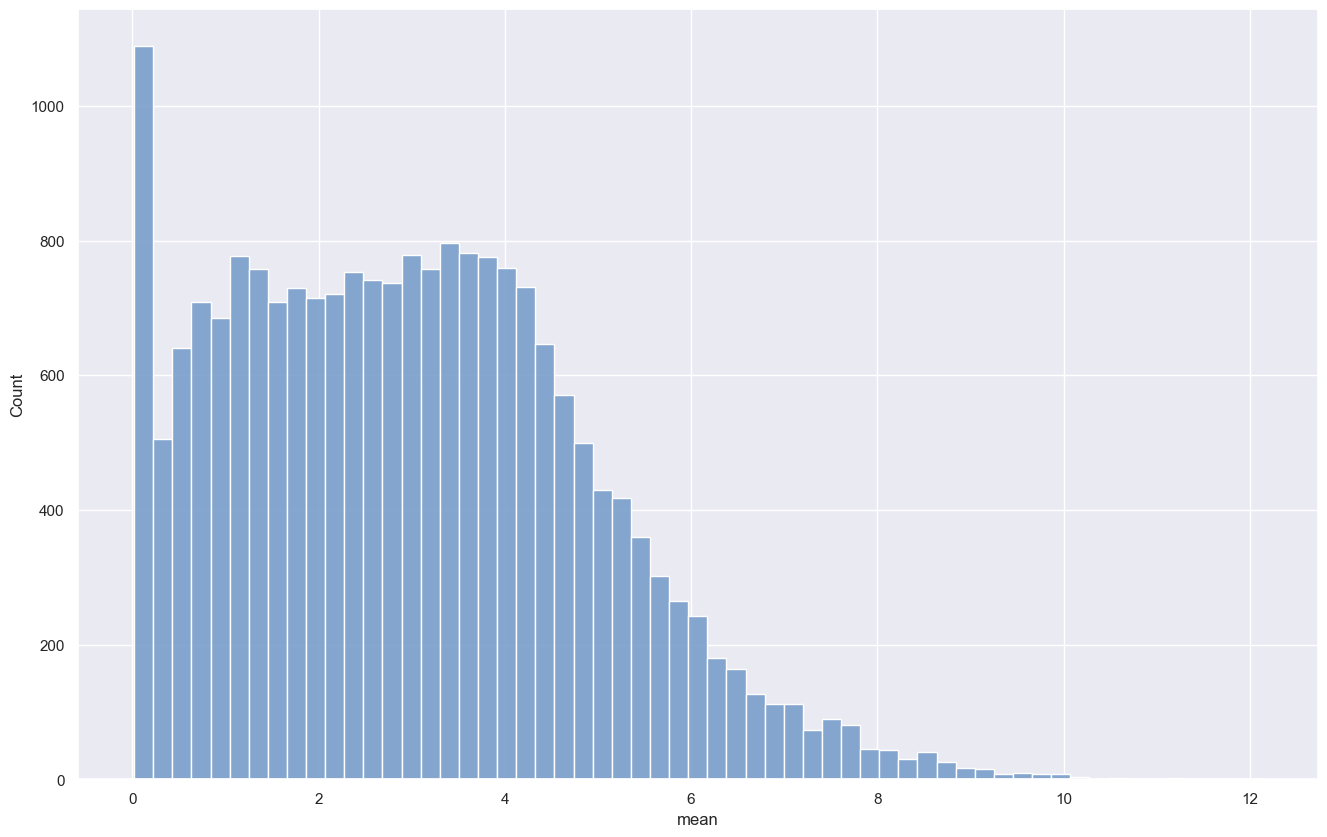

Function : numpy.amax
Genes below 10th percentile [   4.295295] :  2,058
Genes below 30th percentile [   5.641786] :  6,174
Genes above 70th percentile [   7.848366] :  6,174
Genes above 90th percentile [   9.890639] :  2,058



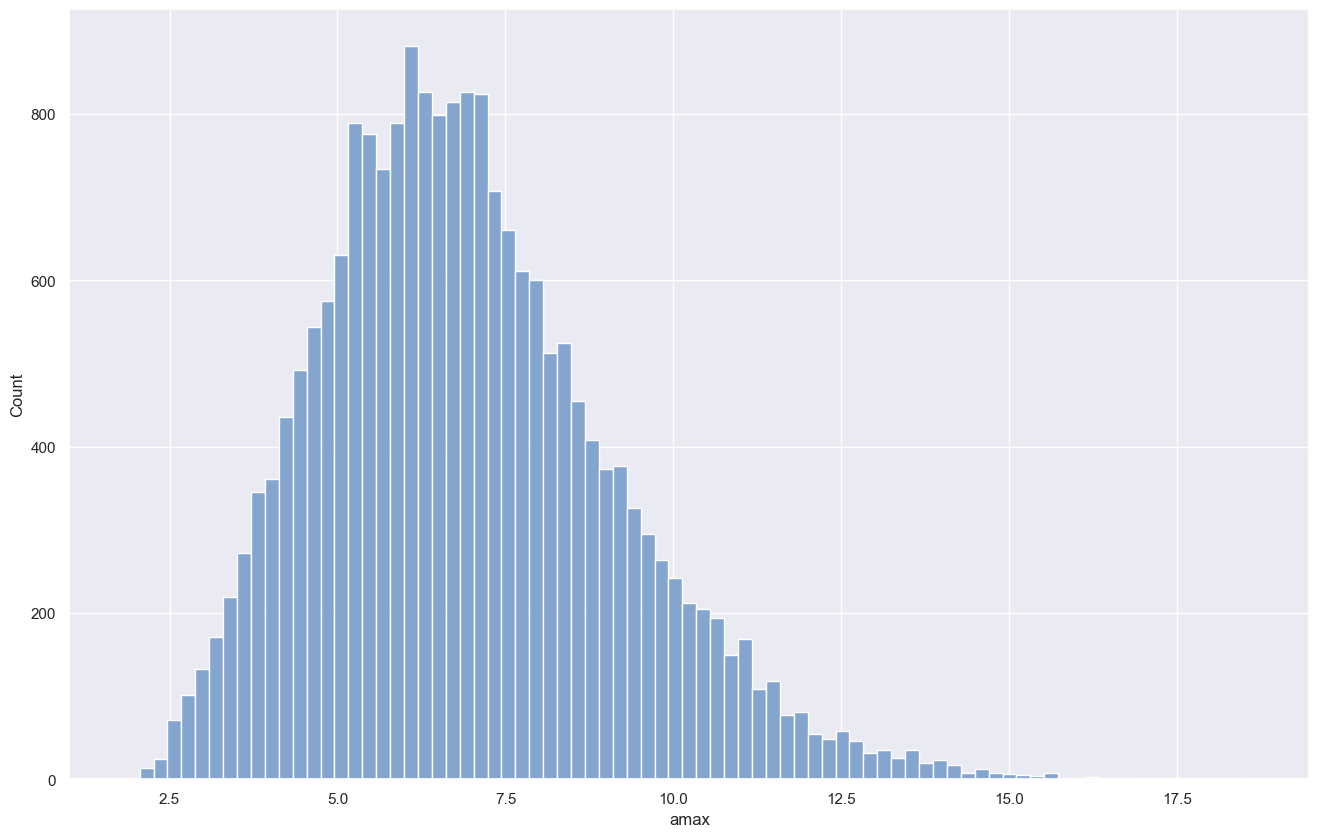

Function : numpy.std
Genes below 10th percentile [   0.611673] :  2,058
Genes below 30th percentile [   0.782785] :  6,174
Genes above 70th percentile [   1.169064] :  6,174
Genes above 90th percentile [   1.682112] :  2,058



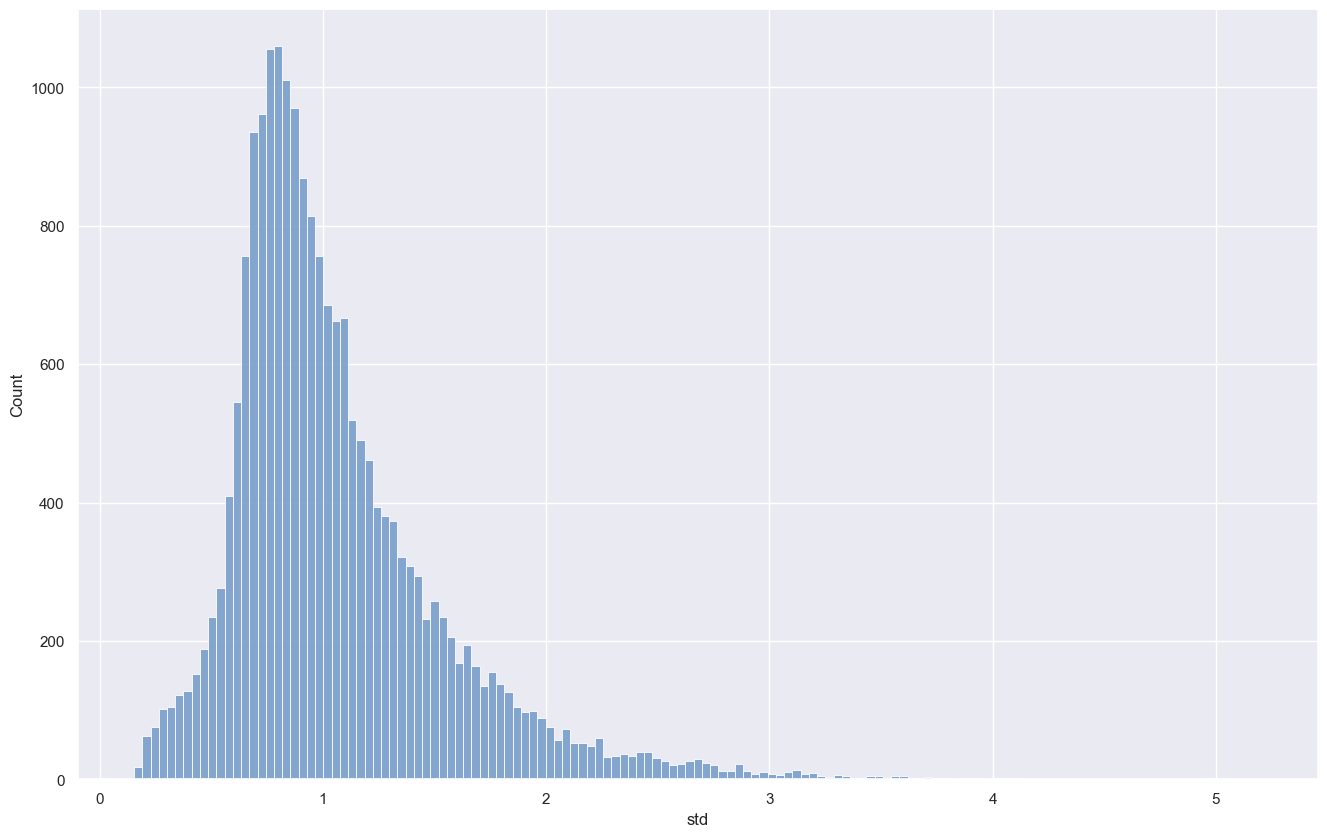

In [18]:
# Display log1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'log1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-log1p-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [   0.006342] :    684
Genes below 30th percentile [   0.024585] :  2,052
Genes above 70th percentile [   0.180606] :  2,052
Genes above 90th percentile [   0.479961] :    684



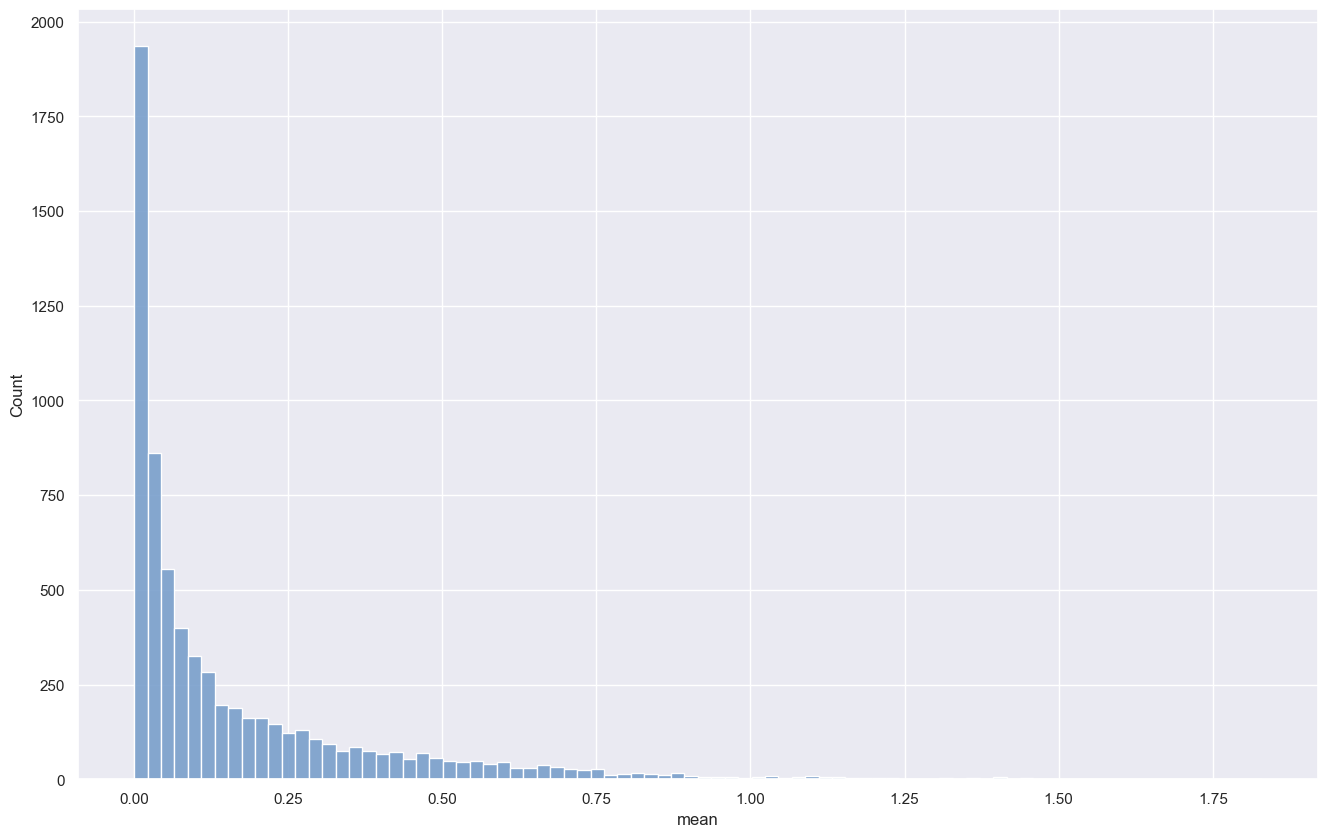

Function : numpy.amax
Genes below 10th percentile [   1.112587] :    684
Genes below 30th percentile [   2.232034] :  2,052
Genes above 70th percentile [   4.485556] :  2,052
Genes above 90th percentile [   6.772176] :    684



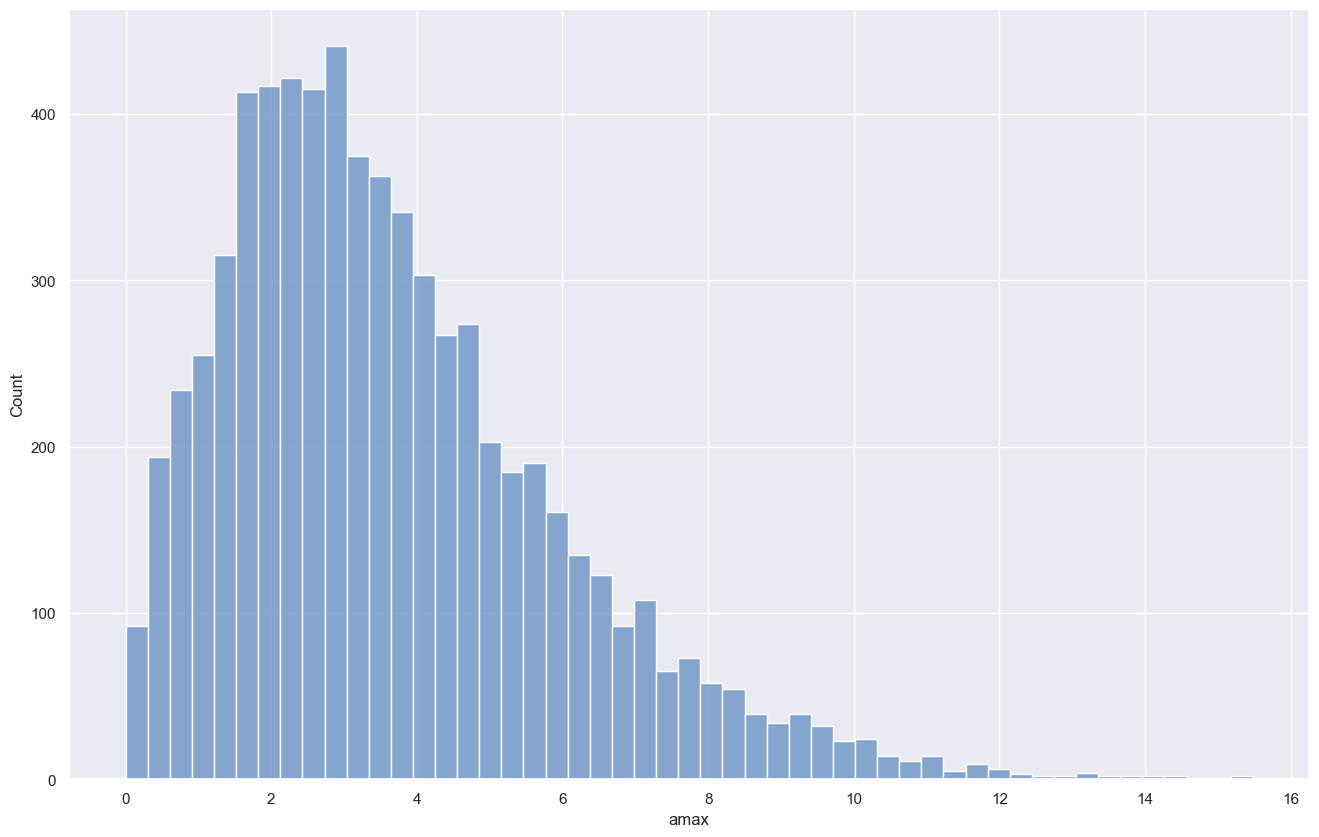

Function : numpy.std
Genes below 10th percentile [   0.049723] :    684
Genes below 30th percentile [   0.140629] :  2,052
Genes above 70th percentile [   0.411935] :  2,052
Genes above 90th percentile [   0.728482] :    684



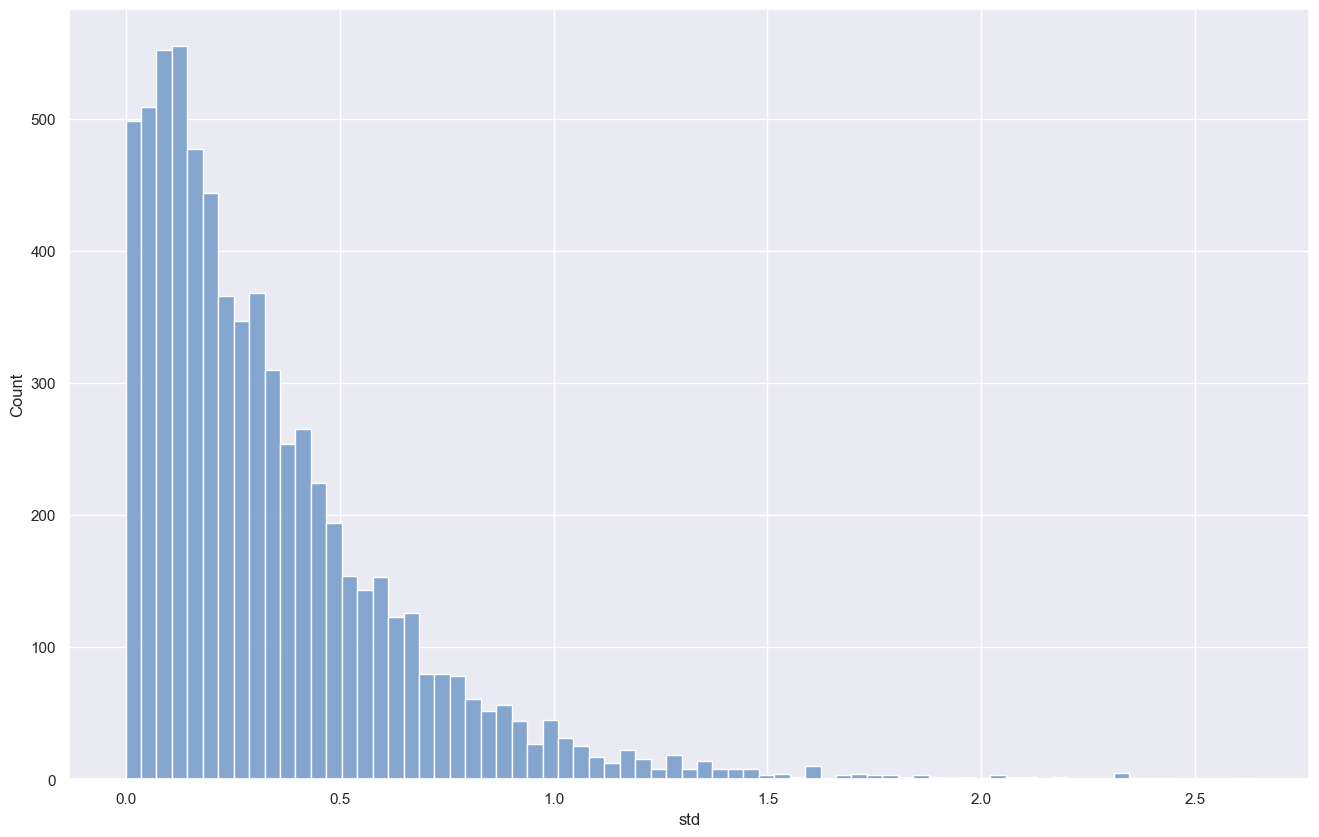

In [19]:
# Display log1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'log1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-log1p-drop-' + name)
	)

	matplotlib.pyplot.show()

## 3.3 Transcripts

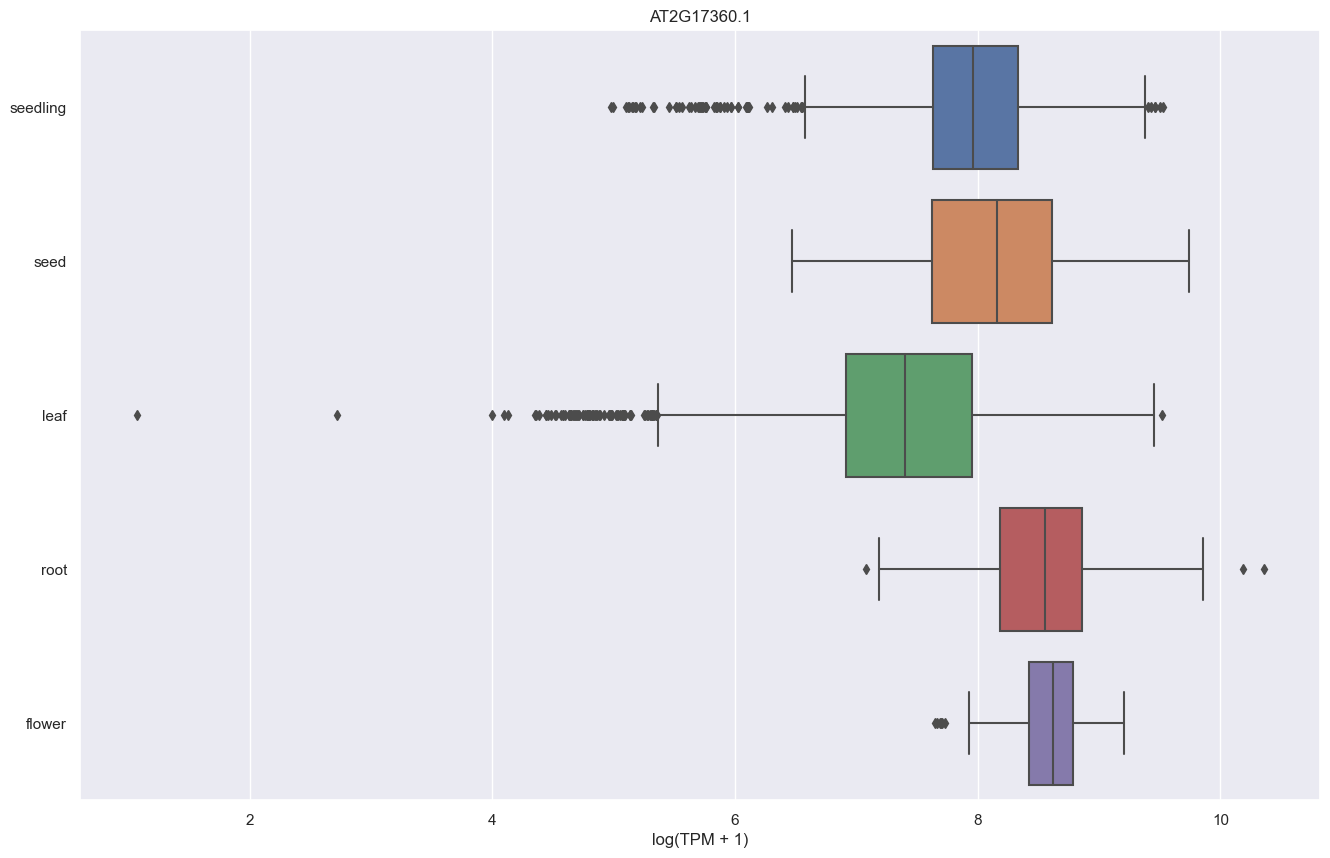

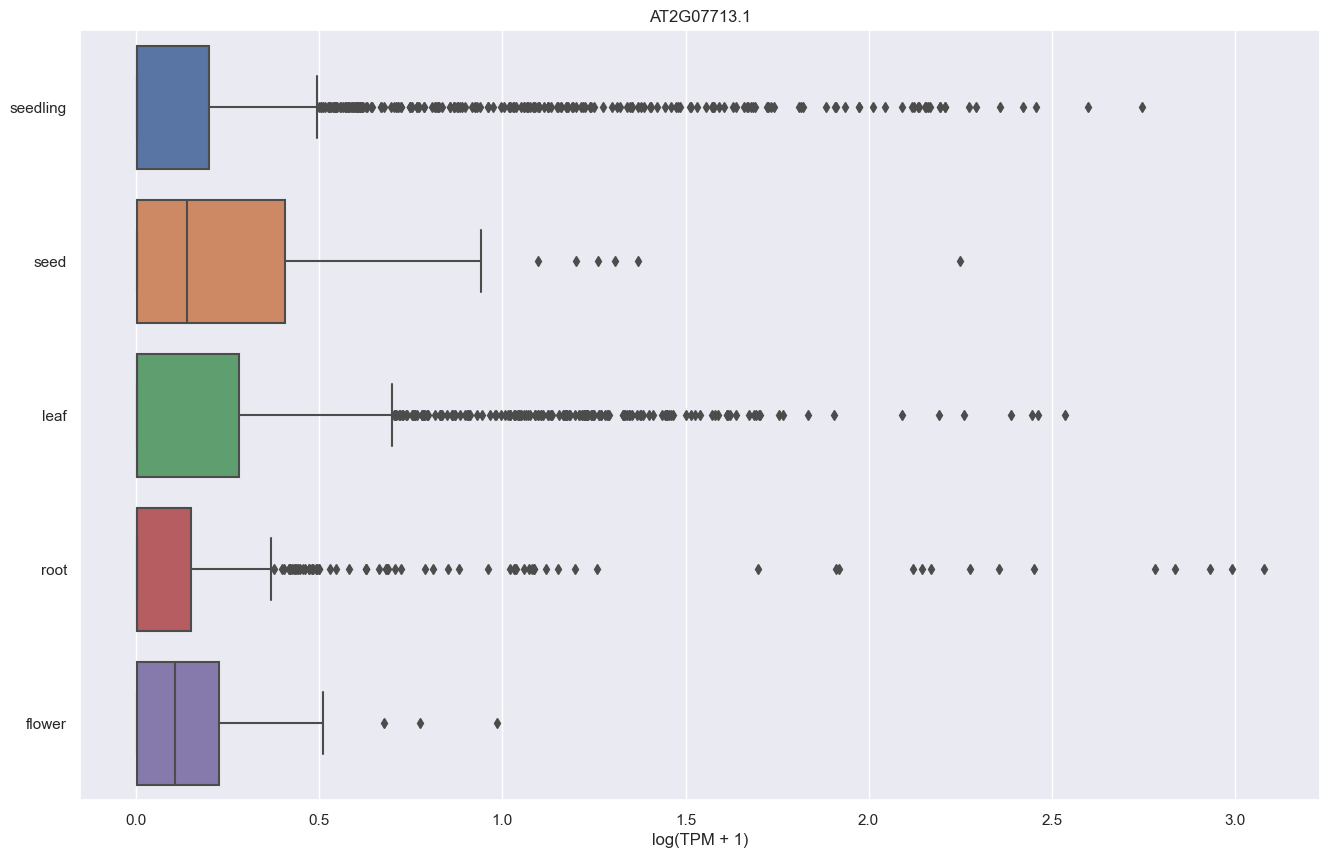

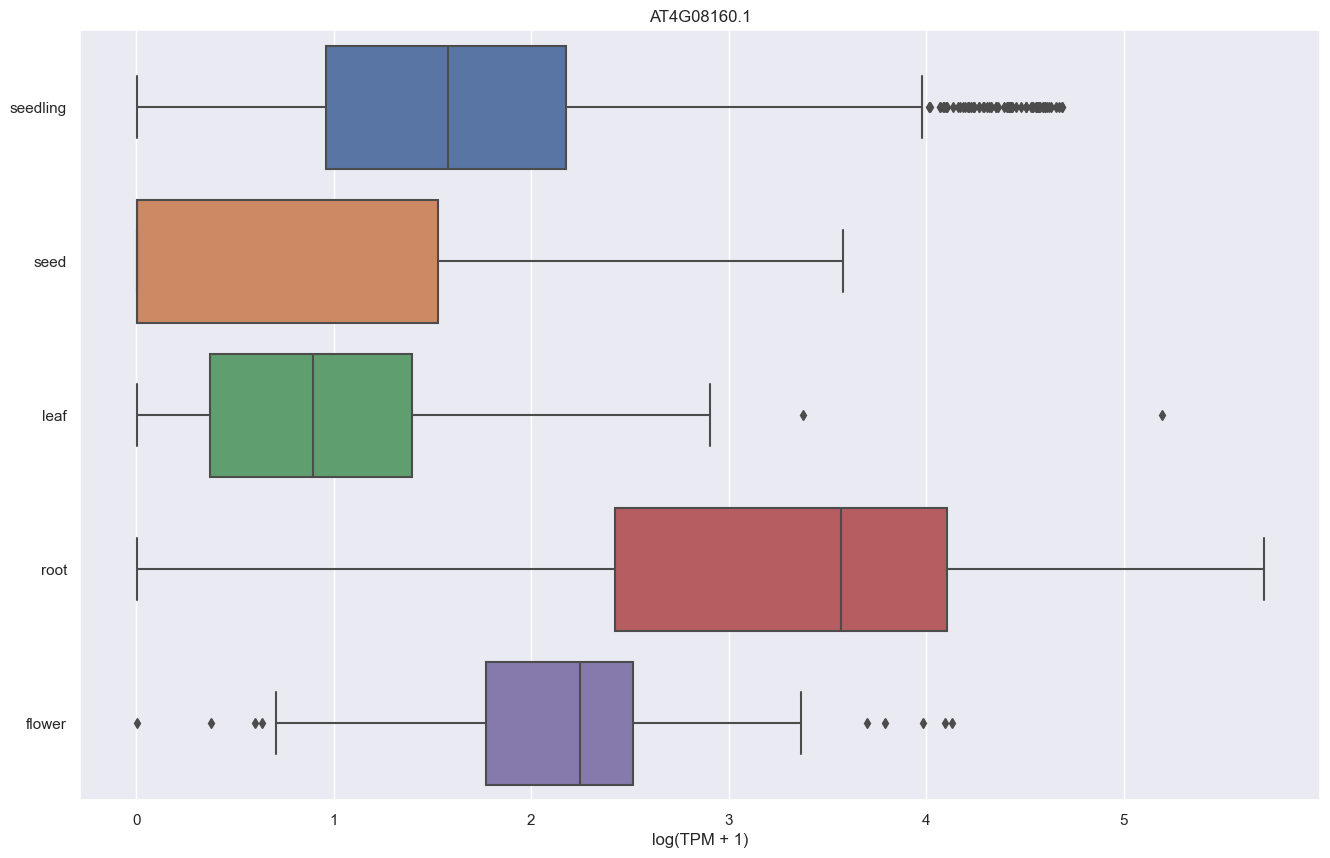

In [20]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'log1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-log1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 4. BoxCox

In [21]:
# Compute and save the boxcox1p tpm values

anndata, boxcox_factors = feature_anndata.compute_boxcox1p(
	data       = anndata,
	store_into = 'boxcox1p',
	layer      = mapping['boxcox1p'],
	eps        =  1.0000000000000000,
	lmbda      = -0.1455266110158969
)

print('Lambda : {}'.format(boxcox_factors['lambda']))

Lambda : -0.1455266110158969


In [22]:
# Display anndata boxcox1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'boxcox1p')

   Max value :   5.82196
  Mean value :   1.28163 ± 1.18748
Median value :   1.13230
   Min value :   0.00000

Total elements        : 111,791,340
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 : 111,791,340 [100.00 %]
Total elements >  1.0 :  58,505,117 [ 52.33 %]
Total elements >  2.0 :  35,608,756 [ 31.85 %]
Total elements >  3.0 :  10,076,607 [  9.01 %]
Total elements >  4.0 :     989,219 [  0.88 %]
Total elements >  5.0 :      16,265 [  0.01 %]

[[  2.393   1.054   0.596   1.877   3.435   0.001   1.853   0.761   3.722   2.999]
 [  2.451   0.001   0.870   1.954   3.460   0.108   1.544   0.867   3.707   2.827]
 [  2.720   0.395   0.498   2.133   3.514   0.001   1.773   0.001   3.719   2.844]
 [  2.603   0.842   0.486   2.018   3.527   0.001   1.135   0.629   3.687   3.063]
 [  2.701   1.039   0.869   1.549   3.587   0.001   1.740   0.001   3.550   1.194]]


## 4.1 Statistics

In [23]:
# Compute basic statistics

dataframes = [
	analysis_statistics.generate_basic_statistics(
		data       = anndata[samples_tissue[tissue]].layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.generate_basic_statistics(
		data       = anndata.layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_boxcox1p_basic = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_boxcox1p_basic.xs(samples_name, level = 0)

,Count,Mean,Median,St. Deviation,Variance,Minimum,Maximum,Range,MAD
Tissue,,,,,,,,,
Seedling,1720,1.862,1.882,0.490,0.240,0.001,3.378,3.377,0.300
Seed,103,1.569,1.560,0.476,0.226,0.300,3.104,2.804,0.228
Leaf,1566,1.391,1.353,0.585,0.342,0.001,3.307,3.306,0.368
Root,606,2.475,2.618,0.497,0.247,0.631,3.493,2.862,0.185
Flower,82,1.683,1.633,0.305,0.093,1.117,2.565,1.448,0.205
Mature_Seedling,1059,1.814,1.854,0.468,0.219,0.285,3.339,3.054,0.290
Young_Seedling,643,1.954,1.911,0.511,0.261,0.001,3.378,3.377,0.319
Mature_Seed,103,1.569,1.560,0.476,0.226,0.300,3.104,2.804,0.228
Mature_Leaf,1442,1.344,1.301,0.565,0.319,0.001,3.212,3.211,0.348


In [24]:
# Compute advance statistics

dataframes = [
	analysis_statistics.genearte_advance_statistics(
		data       = anndata[samples_tissue[tissue]].layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.genearte_advance_statistics(
		data       = anndata.layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_boxcox1p_advance = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_boxcox1p_advance.xs(samples_name, level = 0)

,ZScore-Lower,ZScore-Upper,ZScore-Percent,IQR-Lower,IQR-Upper,IQR-Percent
Tissue,,,,,,
Seedling,0.391,3.333,0.999,0.676,3.066,0.977
Seed,0.142,2.996,0.990,0.633,2.427,0.932
Leaf,-0.365,3.146,0.998,-0.110,2.856,0.989
Root,0.983,3.967,1.000,1.780,3.334,0.893
Flower,0.767,2.599,1.000,0.834,2.444,0.976
Mature_Seedling,0.411,3.218,0.998,0.659,3.011,0.975
Young_Seedling,0.422,3.485,1.000,0.690,3.336,0.992
Mature_Seed,0.142,2.996,0.990,0.633,2.427,0.932
Mature_Leaf,-0.350,3.038,0.998,-0.097,2.753,0.985


In [25]:
# Compute normality statistics

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	dataframes = [
		analysis_statistics.generate_normality_statistics(
			data       = anndata[samples_tissue[tissue]].layers['boxcox1p'].T,
			transcript = transcripts,
			tissue     = tissue
		)

		for tissue in samples_tissue.keys()
	]

	dataframes.append(
		analysis_statistics.generate_normality_statistics(
			data       = anndata.layers['boxcox1p'].T,
			transcript = transcripts,
			tissue     = 'Global'
		)
	)

statistic_boxcox1p_normality = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_boxcox1p_normality.xs(samples_name, level = 0)

,Shapiro-Statistic,Shapiro-pValue,NormalTest-Statistic,NormalTest-pValue,Anderson-Statistic,Anderson-CriticalValue,Anderson-Significance
Tissue,,,,,,,
Seedling,0.993,0.000,29.924,0.000,3.180,1.089,1.000
Seed,0.947,0.000,14.700,0.001,1.835,1.054,1.000
Leaf,0.991,0.000,26.157,0.000,3.553,1.089,1.000
Root,0.869,0.000,154.635,0.000,27.896,1.085,1.000
Flower,0.962,0.017,5.558,0.062,1.032,1.045,1.000
Mature_Seedling,0.987,0.000,31.056,0.000,3.830,1.088,1.000
Young_Seedling,0.985,0.000,10.456,0.005,2.881,1.085,1.000
Mature_Seed,0.947,0.000,14.700,0.001,1.835,1.054,1.000
Mature_Leaf,0.992,0.000,20.381,0.000,2.800,1.089,1.000


## 4.2 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.372556] :  2,058
Genes below 30th percentile [   1.062831] :  6,174
Genes above 70th percentile [   2.241758] :  6,174
Genes above 90th percentile [   2.904302] :  2,058



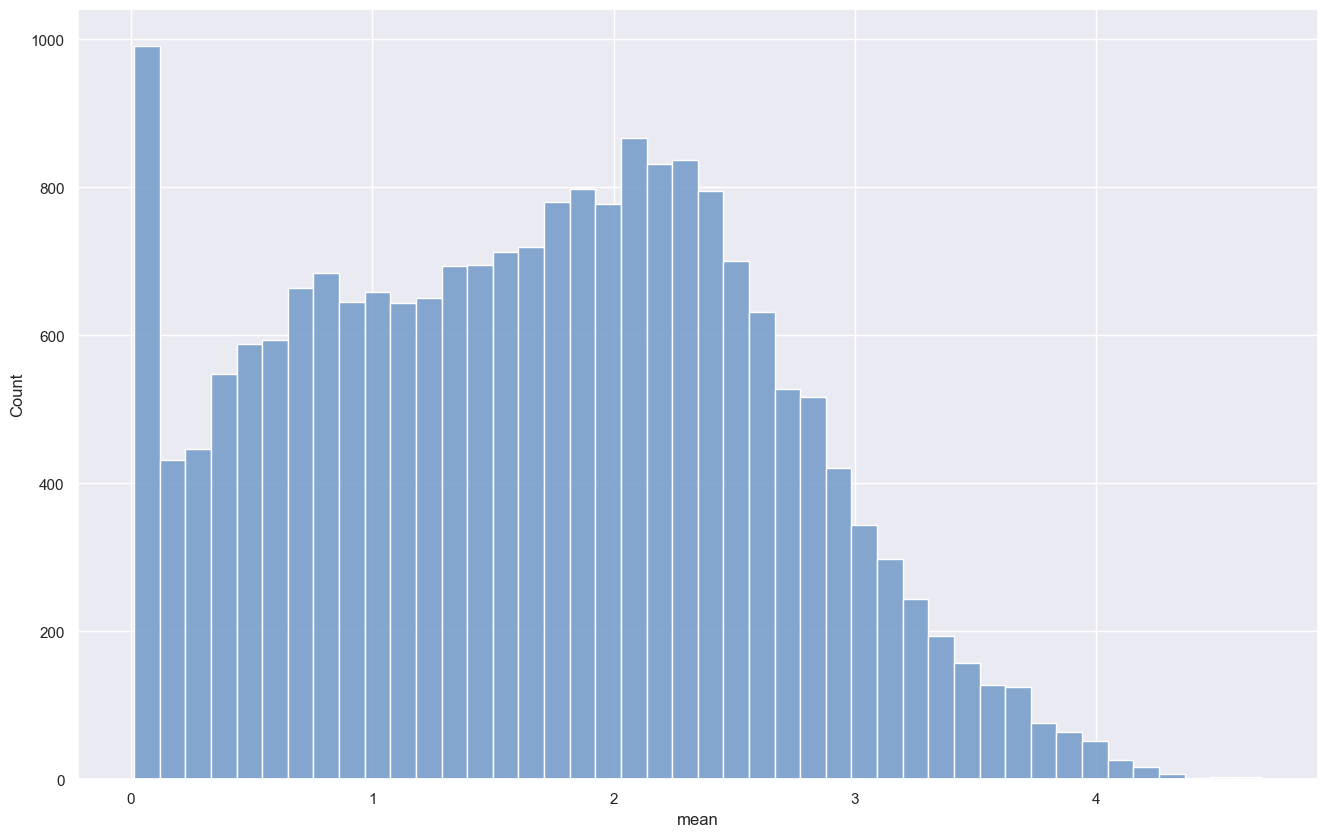

Function : numpy.amax
Genes below 10th percentile [   2.416163] :  2,058
Genes below 30th percentile [   2.982014] :  6,174
Genes above 70th percentile [   3.758178] :  6,174
Genes above 90th percentile [   4.337811] :  2,058



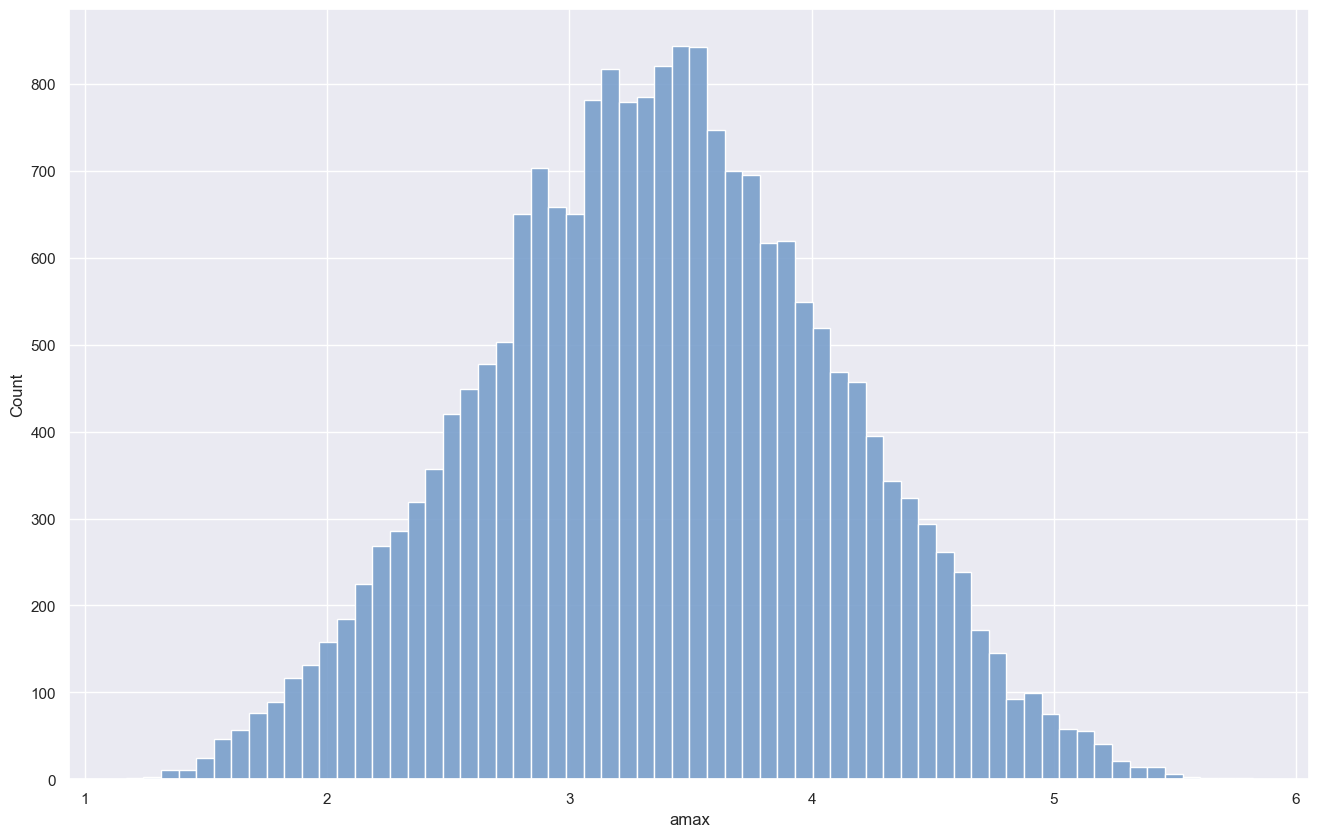

Function : numpy.std
Genes below 10th percentile [   0.317330] :  2,058
Genes below 30th percentile [   0.392908] :  6,174
Genes above 70th percentile [   0.598767] :  6,174
Genes above 90th percentile [   0.846200] :  2,058



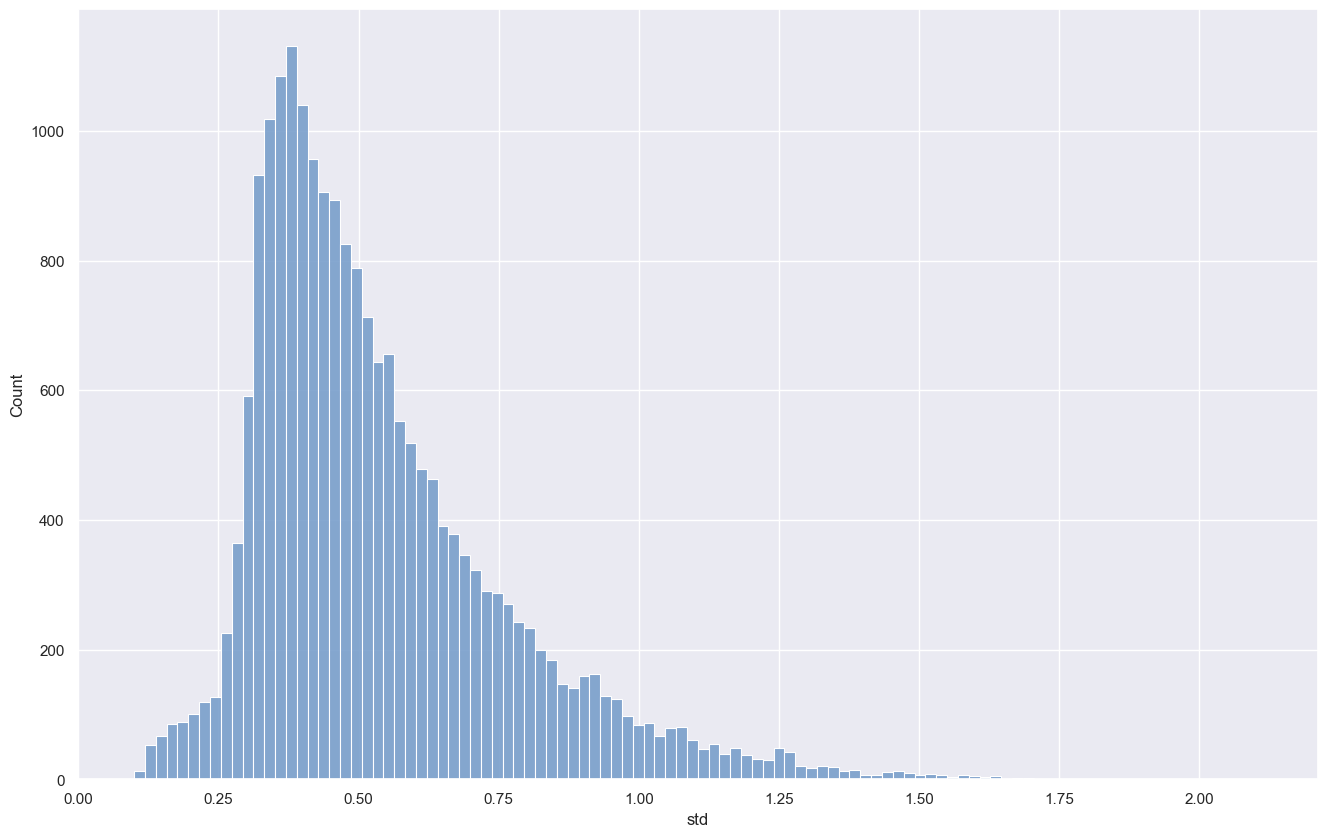

In [26]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'boxcox1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [   0.004242] :    684
Genes below 30th percentile [   0.016024] :  2,052
Genes above 70th percentile [   0.117697] :  2,052
Genes above 90th percentile [   0.310784] :    684



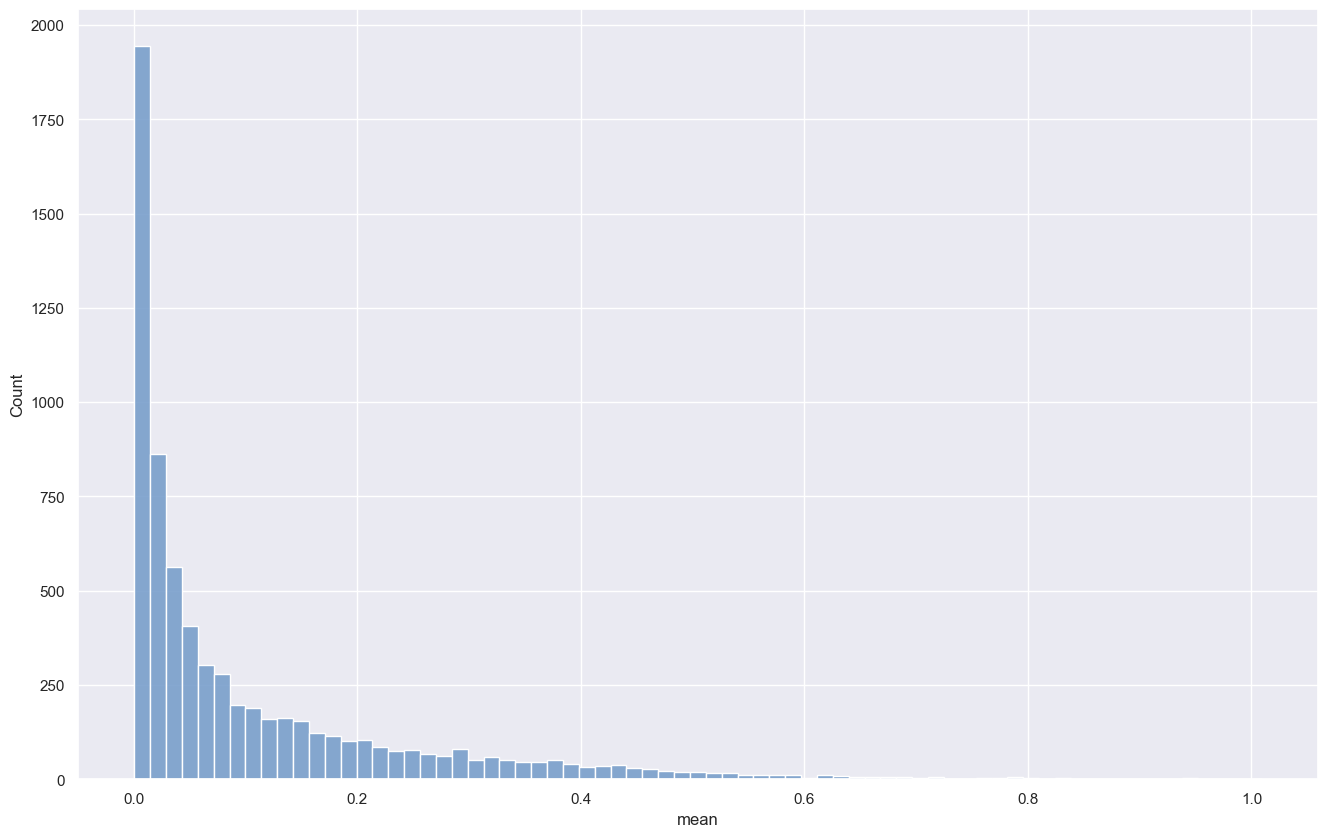

Function : numpy.amax
Genes below 10th percentile [   0.729486] :    684
Genes below 30th percentile [   1.385329] :  2,052
Genes above 70th percentile [   2.500856] :  2,052
Genes above 90th percentile [   3.401168] :    684



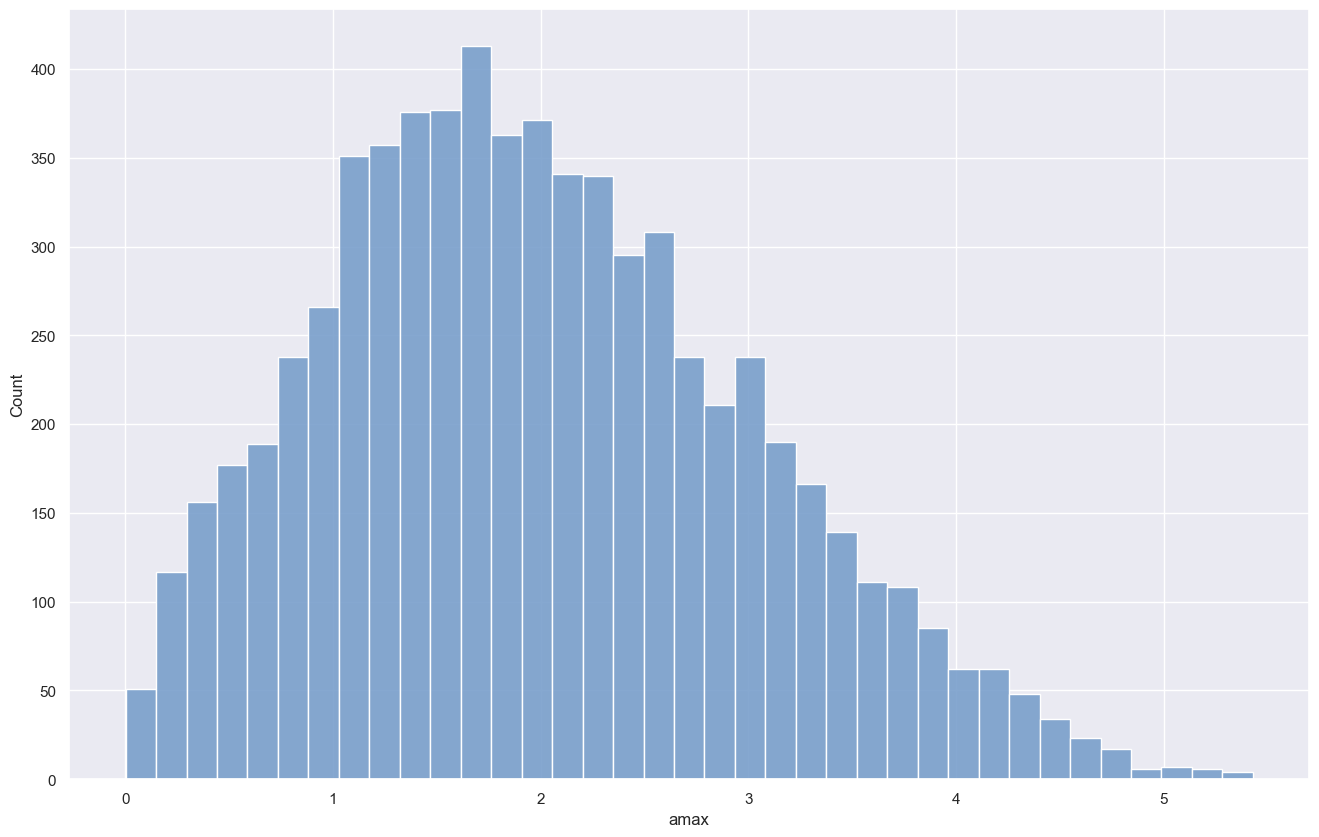

Function : numpy.std
Genes below 10th percentile [   0.033121] :    684
Genes below 30th percentile [   0.090781] :  2,052
Genes above 70th percentile [   0.253545] :  2,052
Genes above 90th percentile [   0.426298] :    684



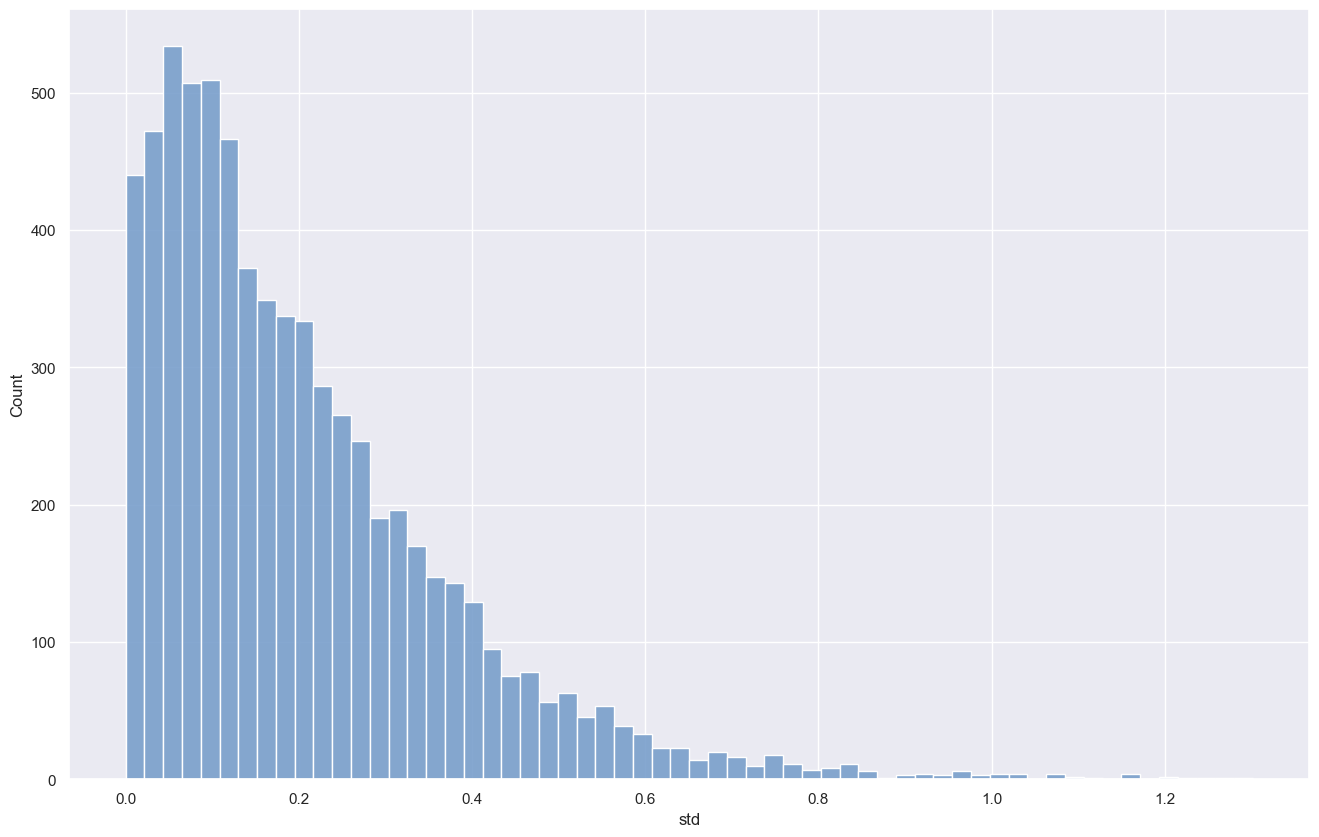

In [27]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'boxcox1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-drop-' + name)
	)

	matplotlib.pyplot.show()

## 4.3 Transcripts

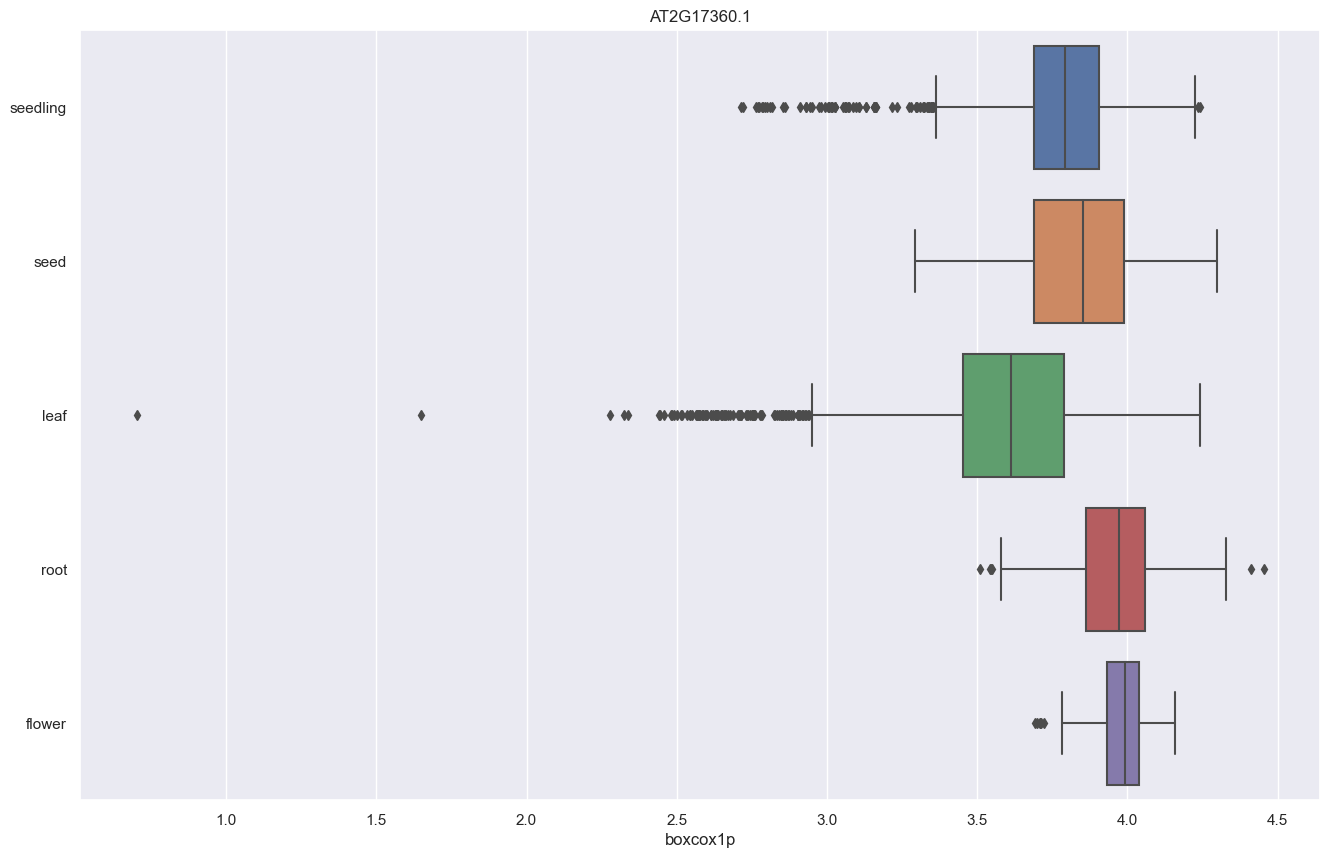

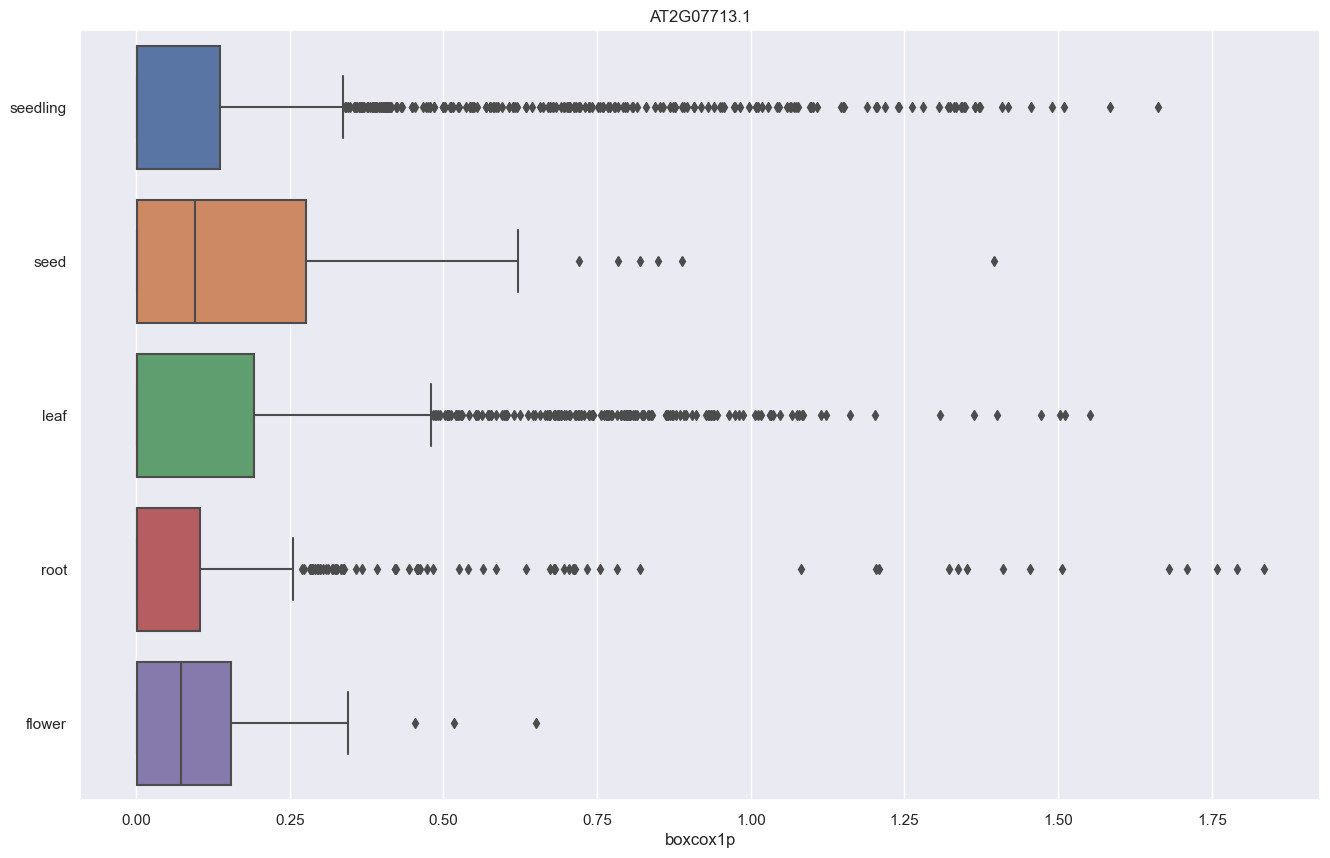

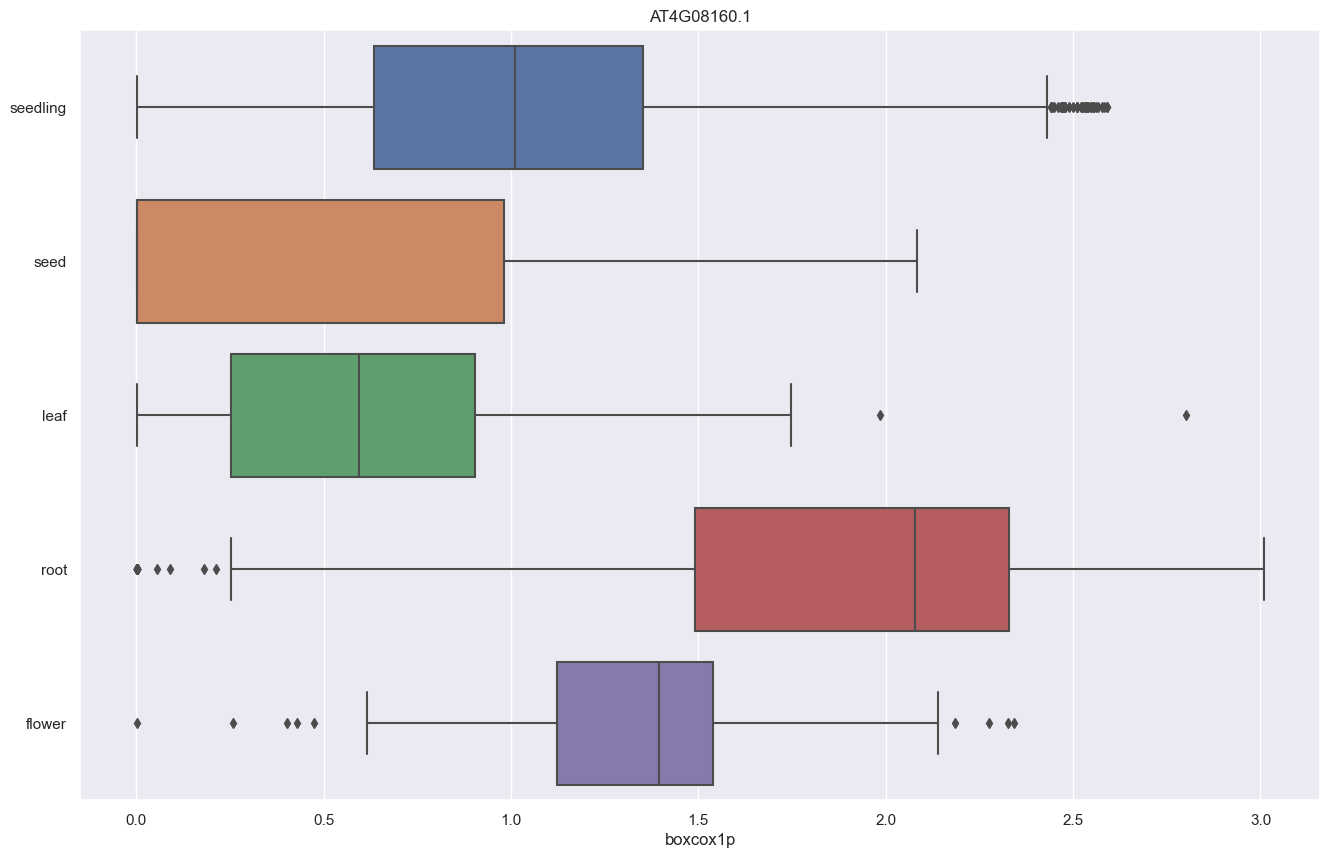

In [28]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'boxcox1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 5. Normal

In [29]:
# Compute and save the normalized tpm values

anndata, normal_factors = feature_anndata.compute_normalized(
	data       = anndata,
	layer      = mapping['normal'],
	store_into = 'normal'
)

print('Min : {}'.format(normal_factors['min']))
print('Max : {}'.format(normal_factors['max']))

Min : 8.406480372883986e-12
Max : 5.8219630427846765


In [30]:
# Display normalized log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'normal')

   Max value :   1.00000
  Mean value :   0.22014 ± 0.20397
Median value :   0.19449
   Min value :   0.00000

Total elements        : 111,791,340
Total elements =  0.0 :           1 [  0.00 %]
Total elements >  0.0 : 111,791,339 [100.00 %]
Total elements >  0.1 :  66,576,584 [ 59.55 %]
Total elements >  0.3 :  42,232,905 [ 37.78 %]
Total elements >  0.5 :  11,744,414 [ 10.51 %]
Total elements >  0.7 :     774,228 [  0.69 %]

[[  0.411   0.181   0.102   0.322   0.590   0.000   0.318   0.131   0.639   0.515]
 [  0.421   0.000   0.150   0.336   0.594   0.019   0.265   0.149   0.637   0.486]
 [  0.467   0.068   0.086   0.366   0.604   0.000   0.304   0.000   0.639   0.489]
 [  0.447   0.145   0.083   0.347   0.606   0.000   0.195   0.108   0.633   0.526]
 [  0.464   0.178   0.149   0.266   0.616   0.000   0.299   0.000   0.610   0.205]]


## 5.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.063992] :  2,058
Genes below 30th percentile [   0.182555] :  6,174
Genes above 70th percentile [   0.385052] :  6,174
Genes above 90th percentile [   0.498853] :  2,058



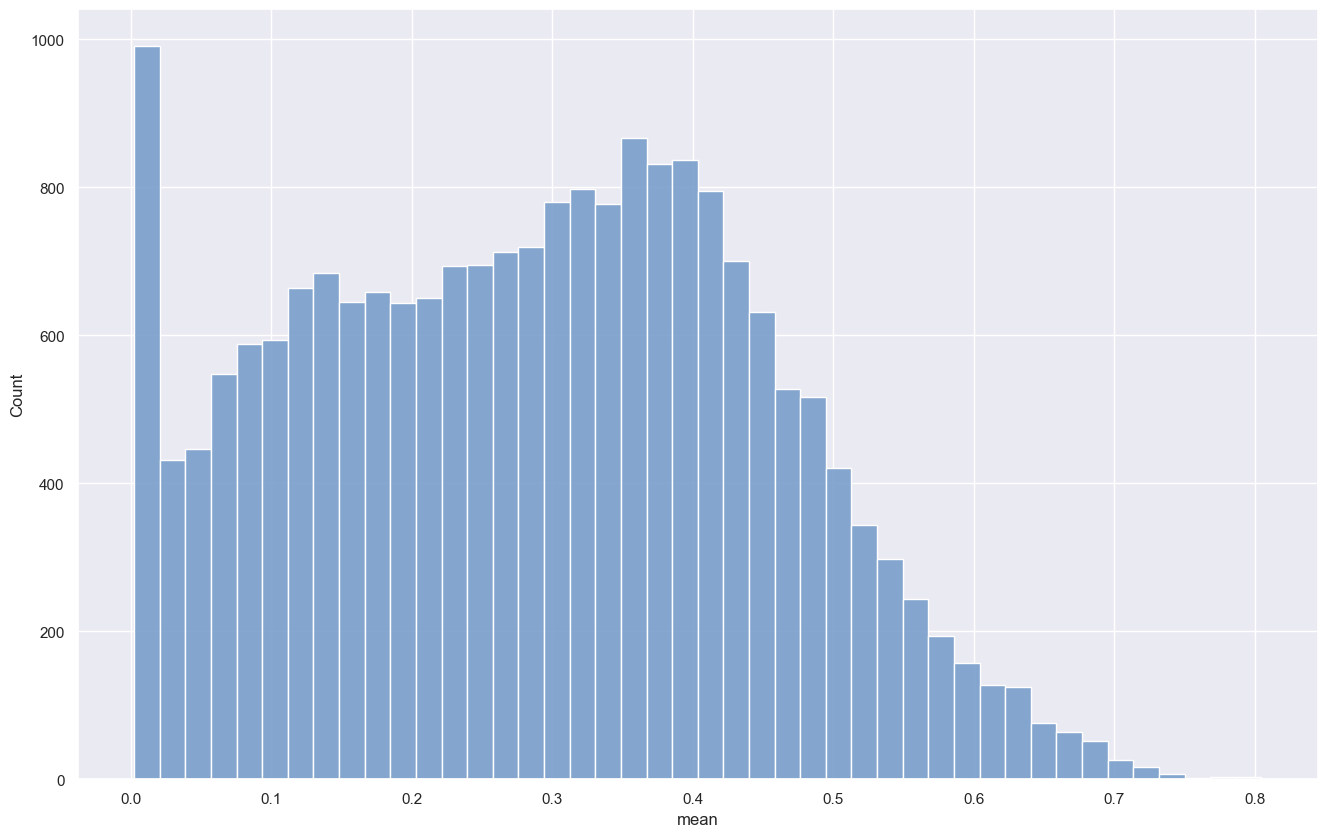

Function : numpy.amax
Genes below 10th percentile [   0.415008] :  2,058
Genes below 30th percentile [   0.512201] :  6,174
Genes above 70th percentile [   0.645517] :  6,174
Genes above 90th percentile [   0.745077] :  2,058



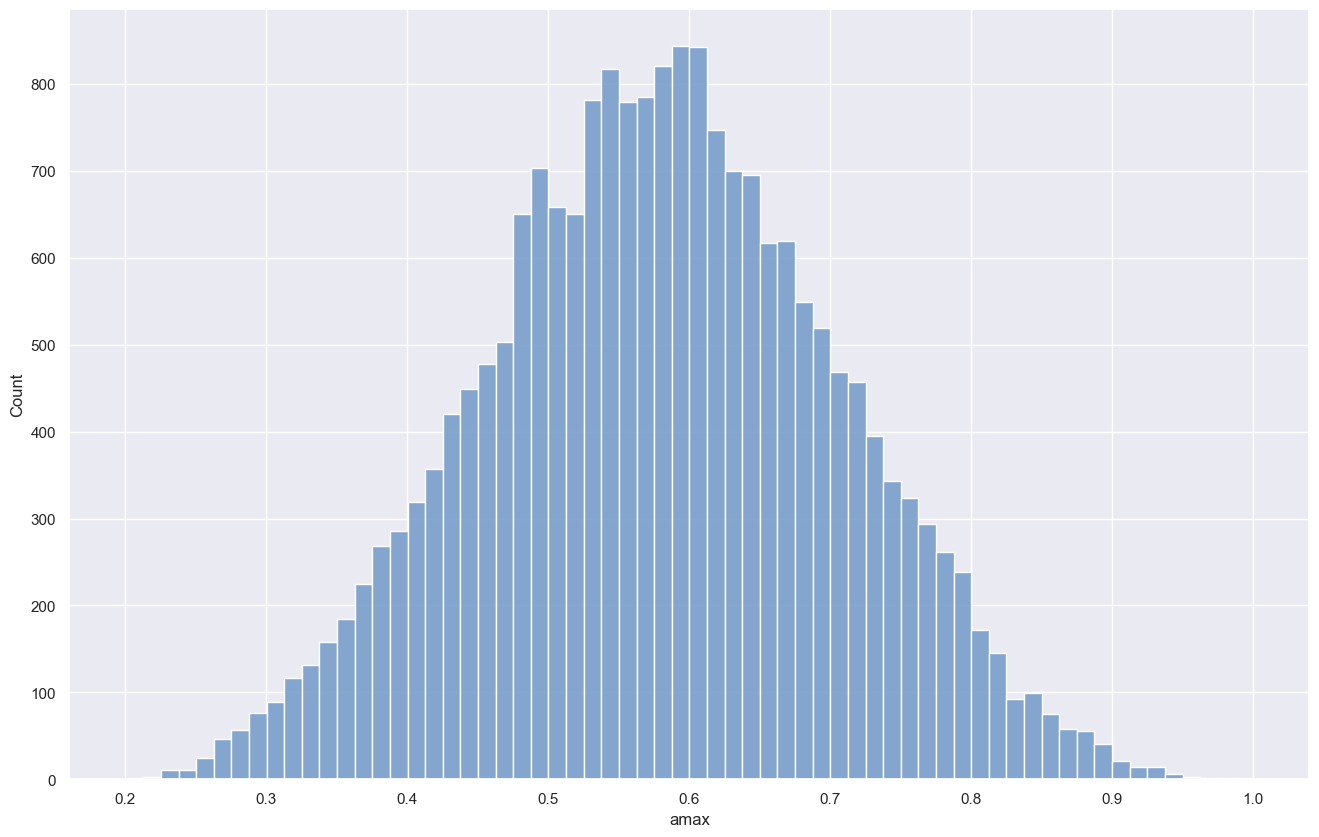

Function : numpy.std
Genes below 10th percentile [   0.054506] :  2,058
Genes below 30th percentile [   0.067487] :  6,174
Genes above 70th percentile [   0.102846] :  6,174
Genes above 90th percentile [   0.145346] :  2,058



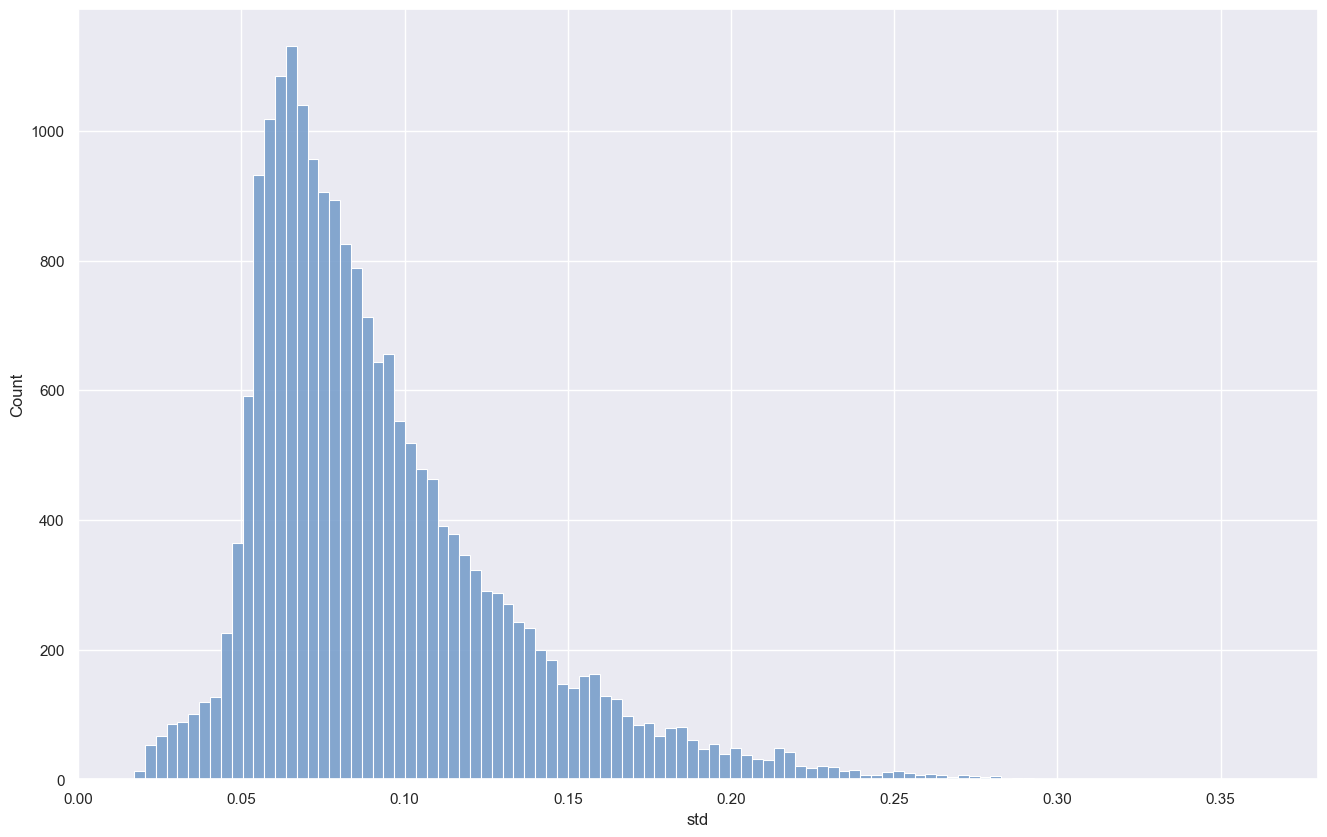

In [31]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'normal',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-nornal-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [   0.000729] :    684
Genes below 30th percentile [   0.002752] :  2,052
Genes above 70th percentile [   0.020216] :  2,052
Genes above 90th percentile [   0.053381] :    684



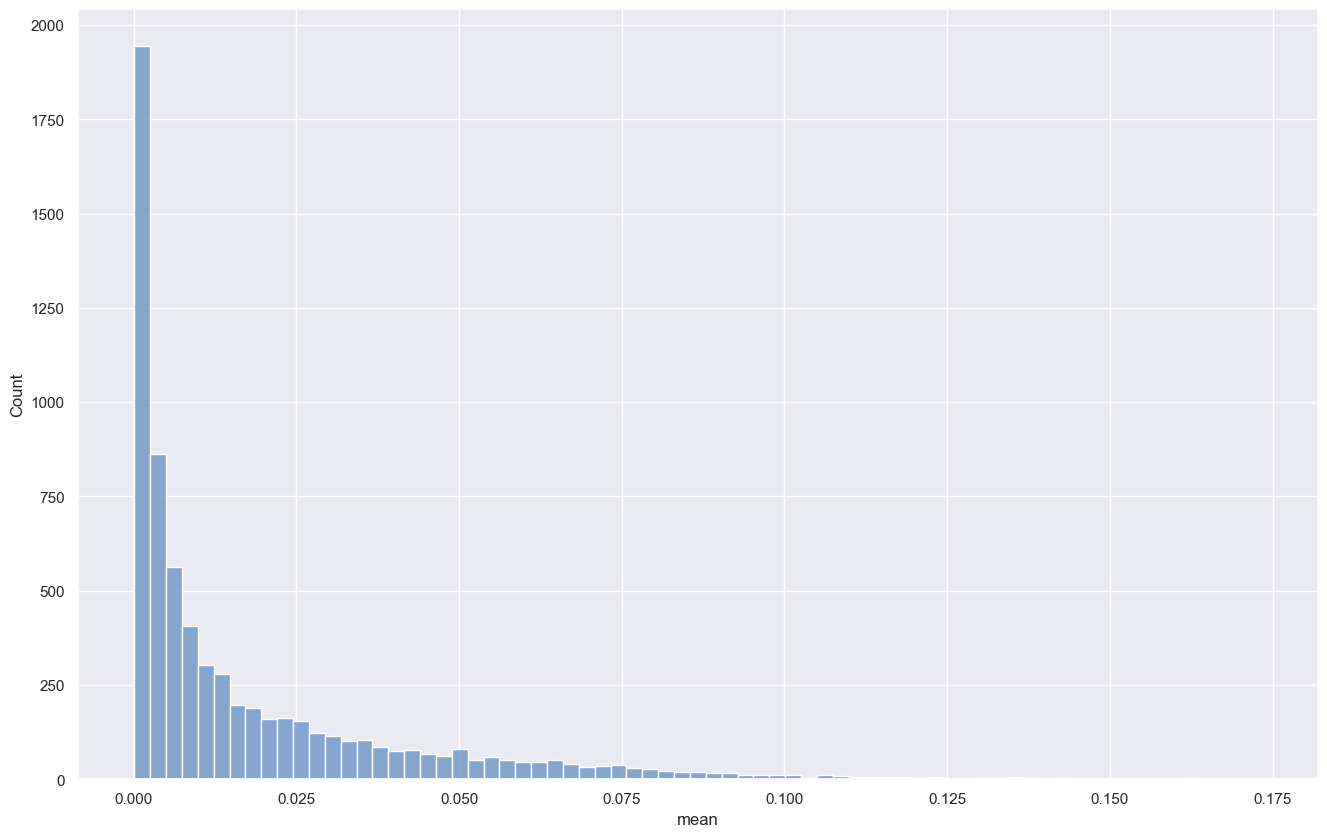

Function : numpy.amax
Genes below 10th percentile [   0.125299] :    684
Genes below 30th percentile [   0.237949] :  2,052
Genes above 70th percentile [   0.429555] :  2,052
Genes above 90th percentile [   0.584196] :    684



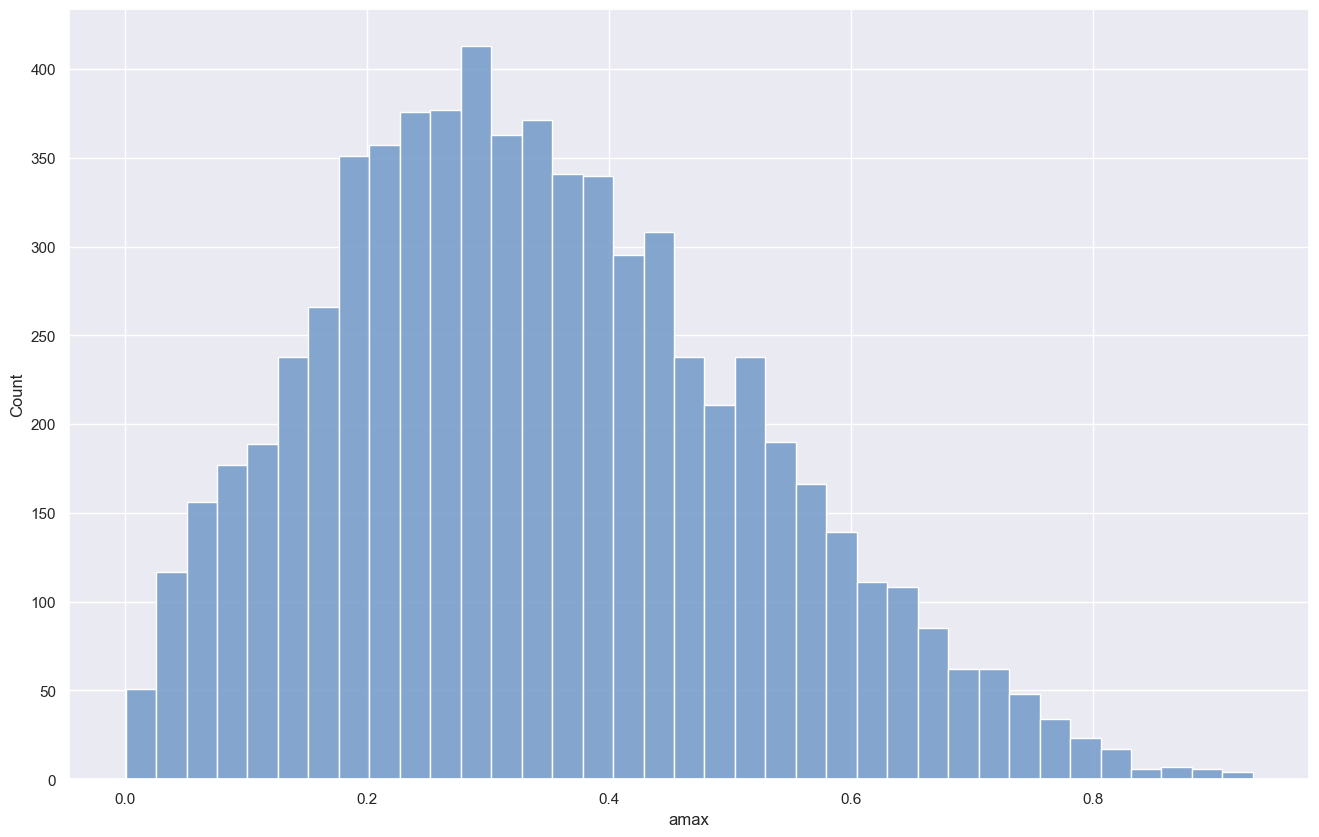

Function : numpy.std
Genes below 10th percentile [   0.005689] :    684
Genes below 30th percentile [   0.015593] :  2,052
Genes above 70th percentile [   0.043550] :  2,052
Genes above 90th percentile [   0.073222] :    684



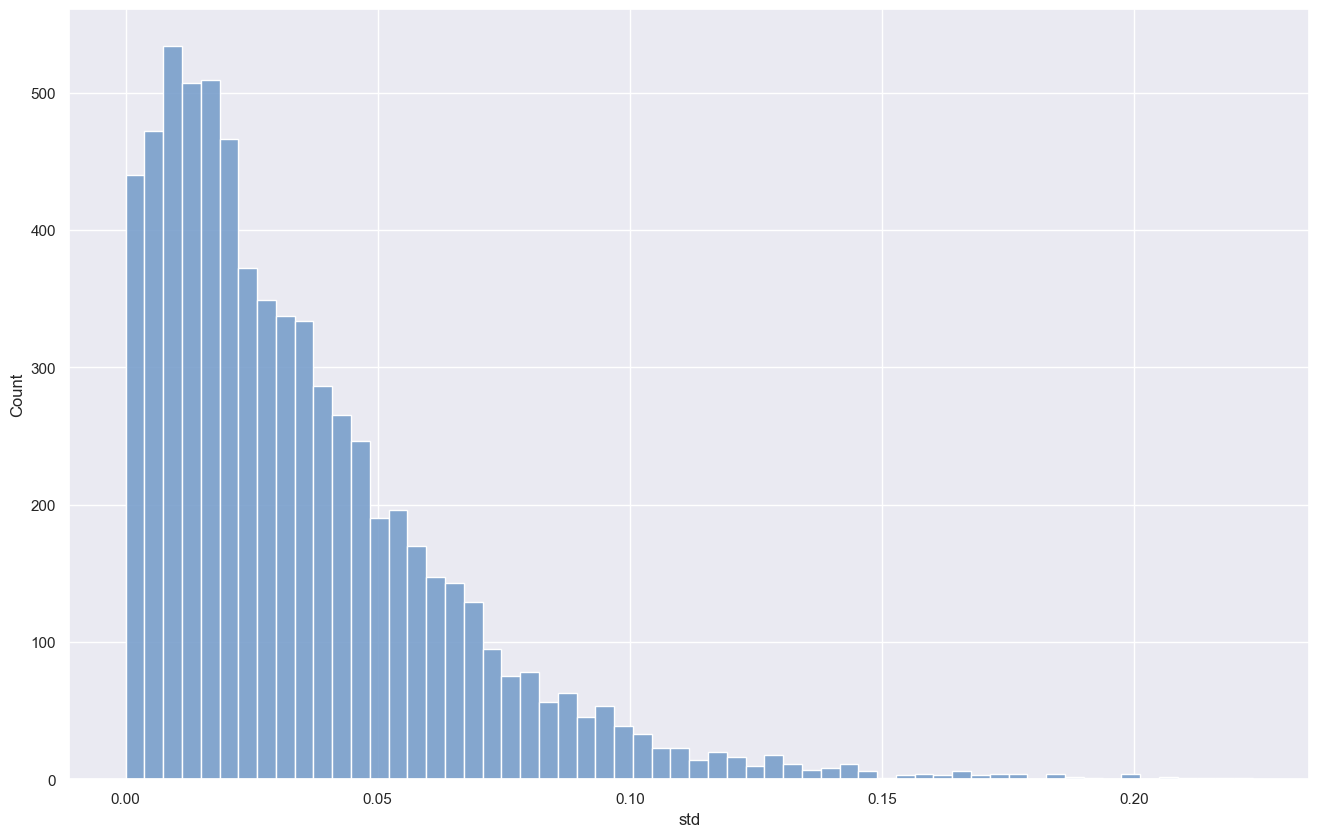

In [32]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'normal',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-normal-drop-' + name)
	)

	matplotlib.pyplot.show()

## 5.2 Transcripts

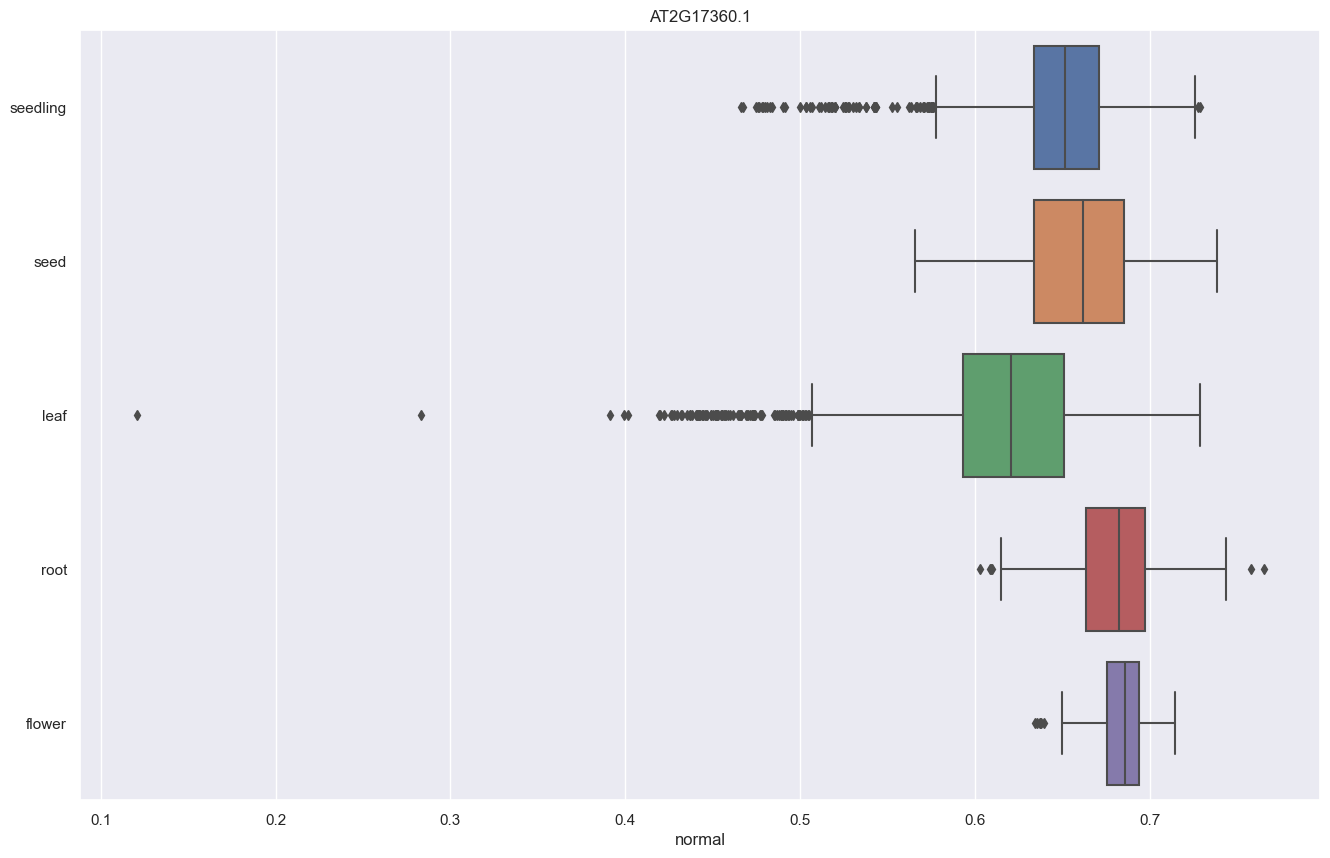

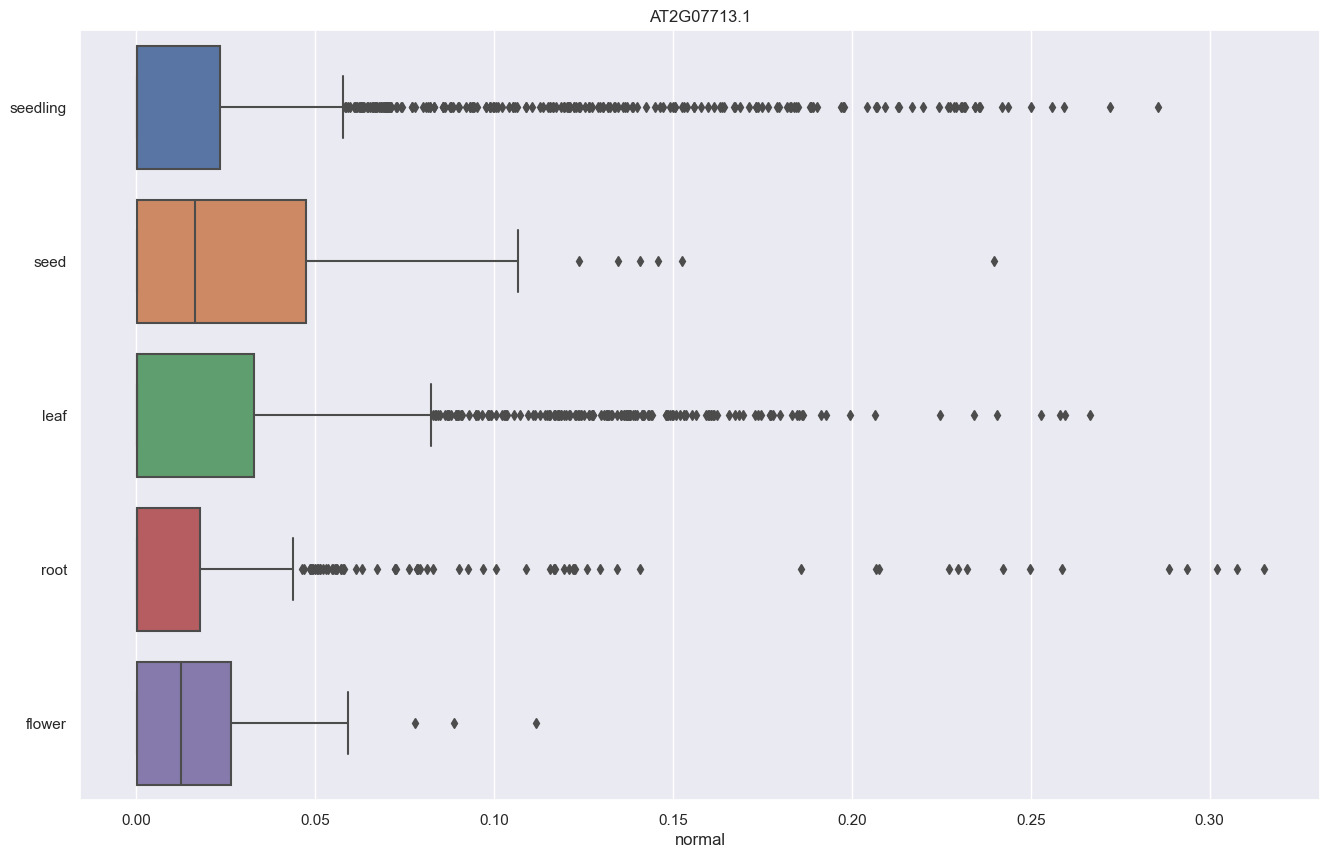

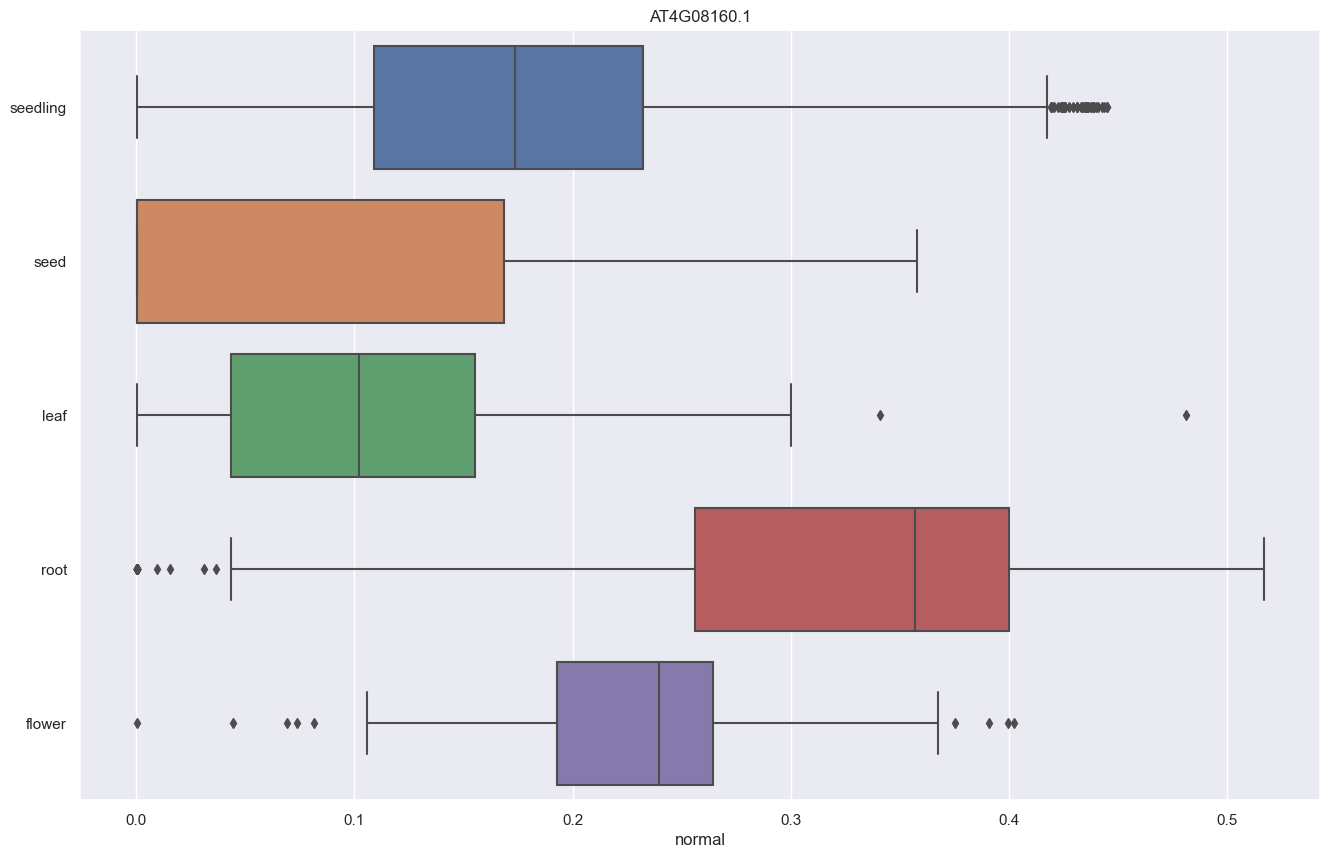

In [33]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'normal',
		filename   = os.path.join(OUT_PLOT, 'tissue-normal-' + transcript)
	)

	matplotlib.pyplot.show()

# 6. Standard

In [34]:
# Compute and save the standardized tpm values

anndata, standard_factors = feature_anndata.compute_standardized(
	data       = anndata,
	layer      = mapping['standard'],
	store_into = 'standard',
	axis       = None
)

print('Mean : {}'.format(standard_factors['mean']))
print(' Std : {}'.format(standard_factors['std']))

Mean : 1.2816280104960043
 Std : 1.1874773693835219


In [35]:
# Display anndata standardized tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'standard')

   Max value :   3.82351
  Mean value :   0.00000 ± 1.00000
Median value :  -0.12575
   Min value :  -1.07929

Total elements        : 111,791,340
Total elements < -1.0 :  32,903,079 [ 29.43 %]
Total elements < -0.5 :  47,279,203 [ 42.29 %]
Total elements < -0.3 :  51,839,751 [ 46.37 %]
Total elements < -0.0 :  58,952,079 [ 52.73 %]
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  52,839,261 [ 47.27 %]
Total elements >  0.3 :  44,888,006 [ 40.15 %]
Total elements >  0.5 :  38,941,716 [ 34.83 %]
Total elements >  1.0 :  22,414,217 [ 20.05 %]
Total elements >  2.0 :   2,556,308 [  2.29 %]

[[  0.936  -0.192  -0.577   0.501   1.813  -1.078   0.481  -0.438   2.055   1.446]
 [  0.985  -1.078  -0.346   0.567   1.834  -0.988   0.221  -0.350   2.042   1.301]
 [  1.211  -0.747  -0.660   0.717   1.880  -1.078   0.414  -1.078   2.053   1.316]
 [  1.113  -0.370  -0.670   0.620   1.891  -1.078  -0.123  -0.550   2.025   1.500]
 [  1.195  -0.205  -0.347   0.225   1.941  -1.078 

## 6.1 Distribution

Function : numpy.mean
Genes below 10th percentile [  -0.765549] :  2,058
Genes below 30th percentile [  -0.184254] :  6,174
Genes above 70th percentile [   0.808546] :  6,174
Genes above 90th percentile [   1.366488] :  2,058



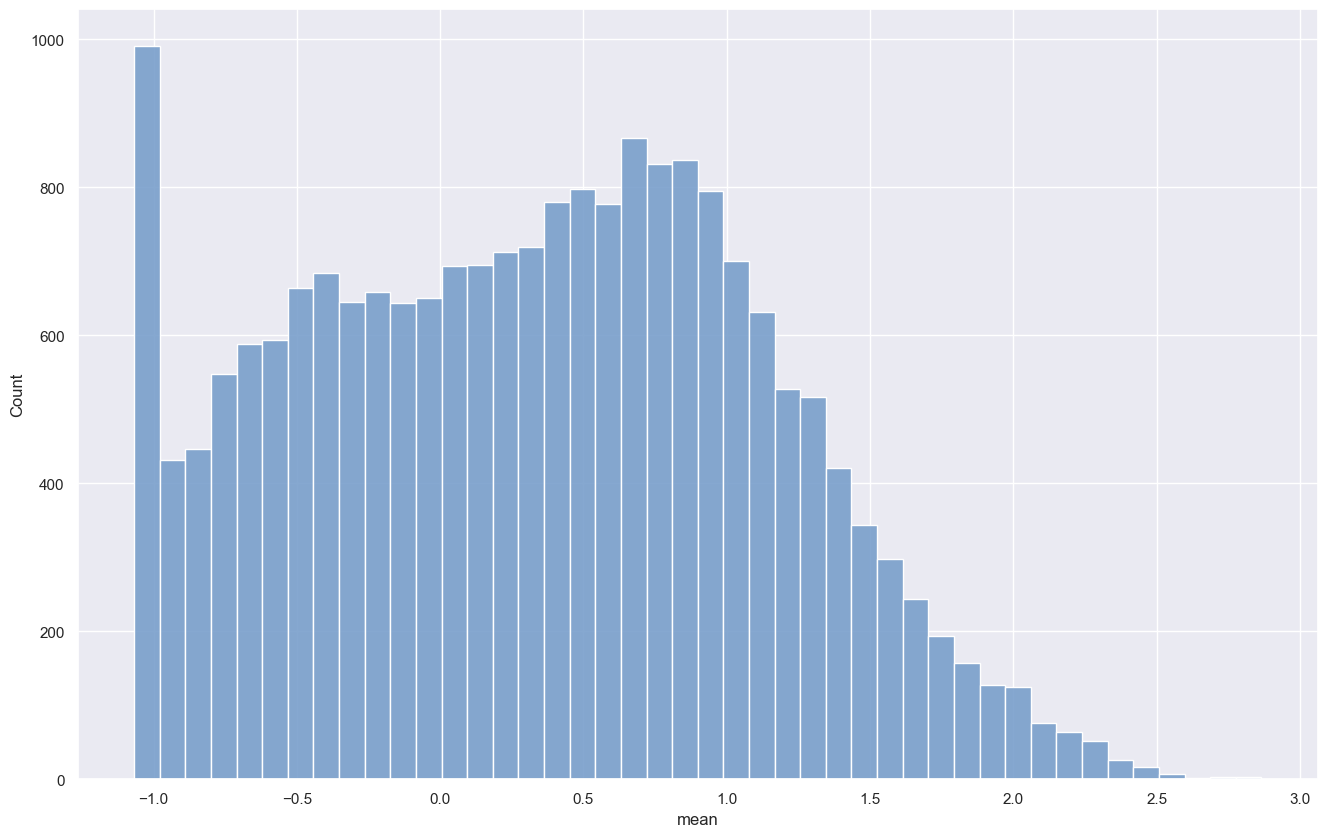

Function : numpy.amax
Genes below 10th percentile [   0.955416] :  2,058
Genes below 30th percentile [   1.431931] :  6,174
Genes above 70th percentile [   2.085556] :  6,174
Genes above 90th percentile [   2.573677] :  2,058



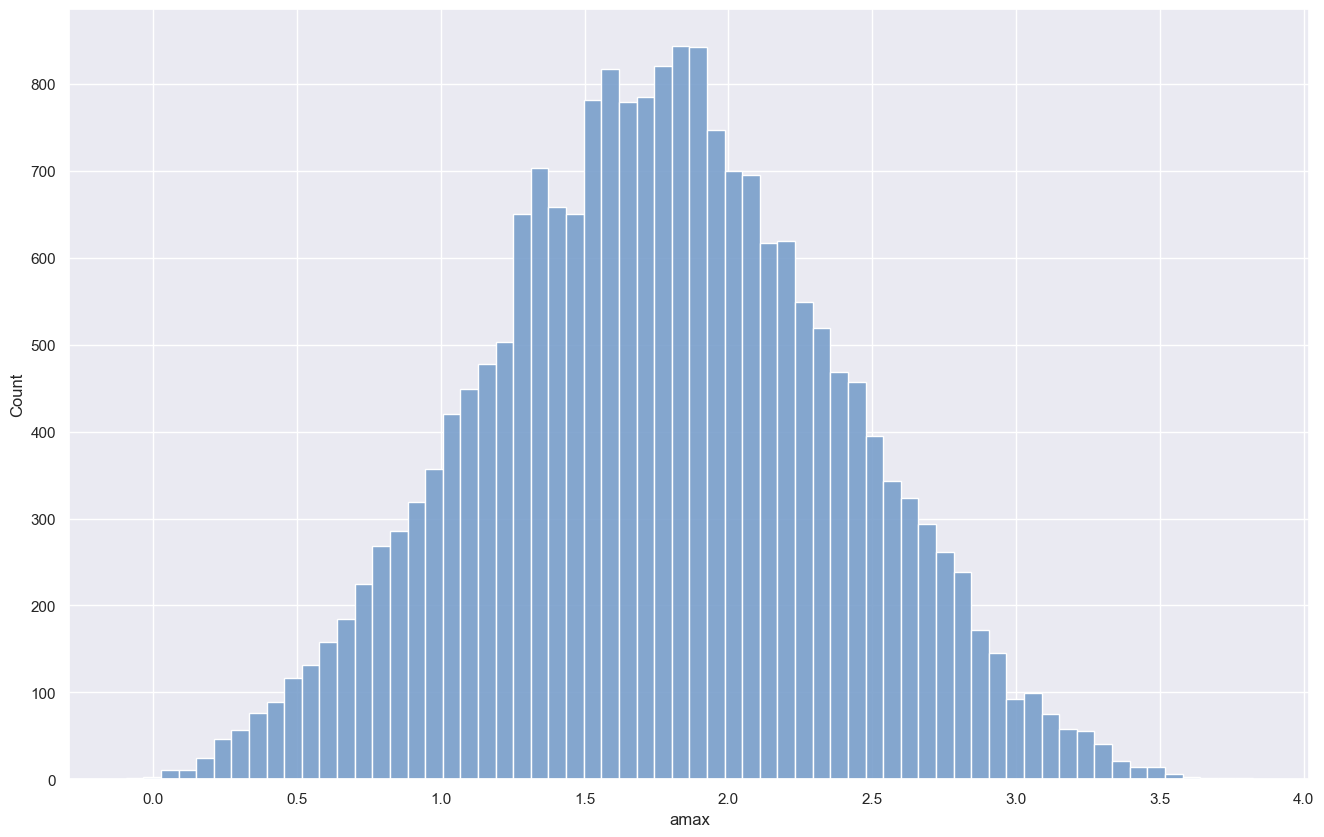

Function : numpy.std
Genes below 10th percentile [   0.267231] :  2,058
Genes below 30th percentile [   0.330876] :  6,174
Genes above 70th percentile [   0.504234] :  6,174
Genes above 90th percentile [   0.712603] :  2,058



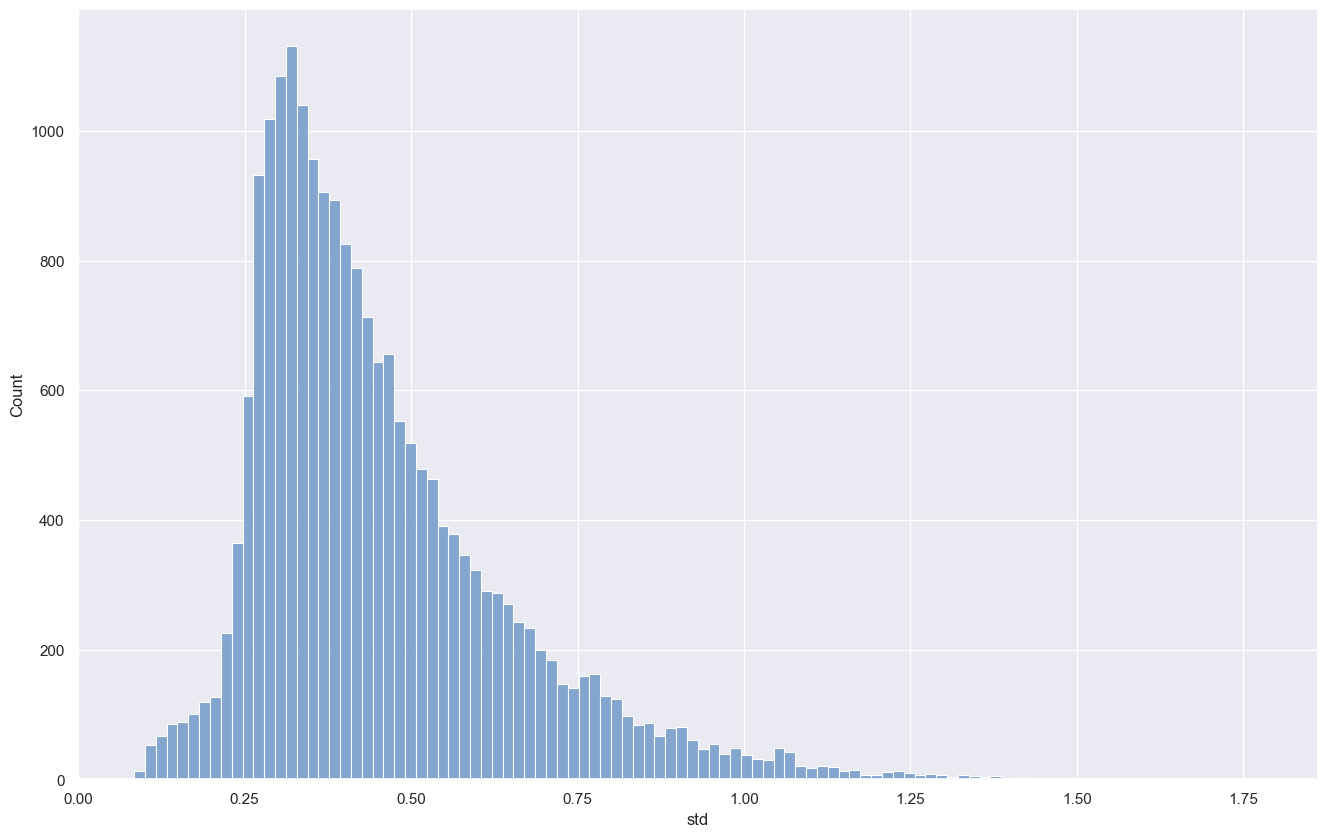

In [36]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'standard',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-standard-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [  -1.075714] :    684
Genes below 30th percentile [  -1.065792] :  2,052
Genes above 70th percentile [  -0.980171] :  2,052
Genes above 90th percentile [  -0.817568] :    684



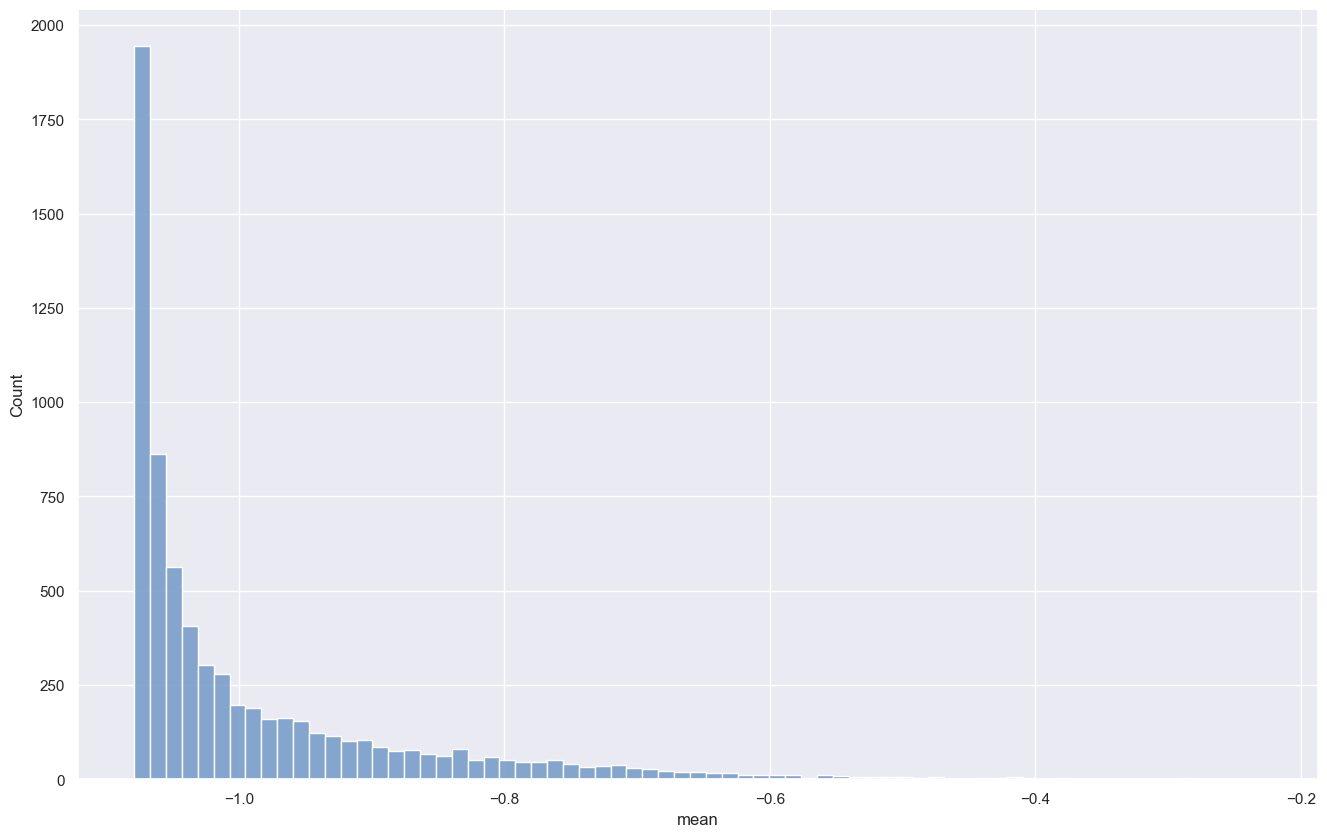

Function : numpy.amax
Genes below 10th percentile [  -0.464970] :    684
Genes below 30th percentile [   0.087329] :  2,052
Genes above 70th percentile [   1.026738] :  2,052
Genes above 90th percentile [   1.784910] :    684



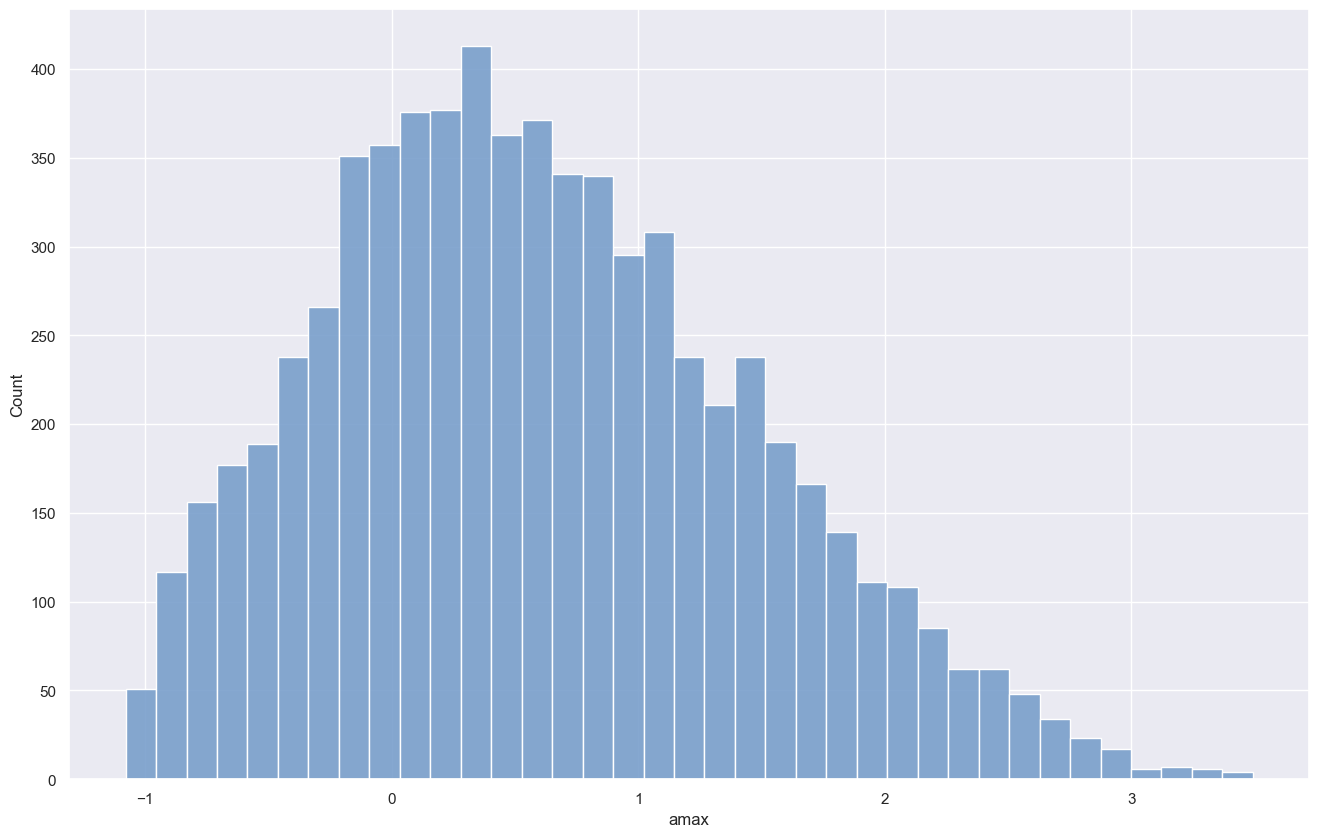

Function : numpy.std
Genes below 10th percentile [   0.027892] :    684
Genes below 30th percentile [   0.076449] :  2,052
Genes above 70th percentile [   0.213516] :  2,052
Genes above 90th percentile [   0.358995] :    684



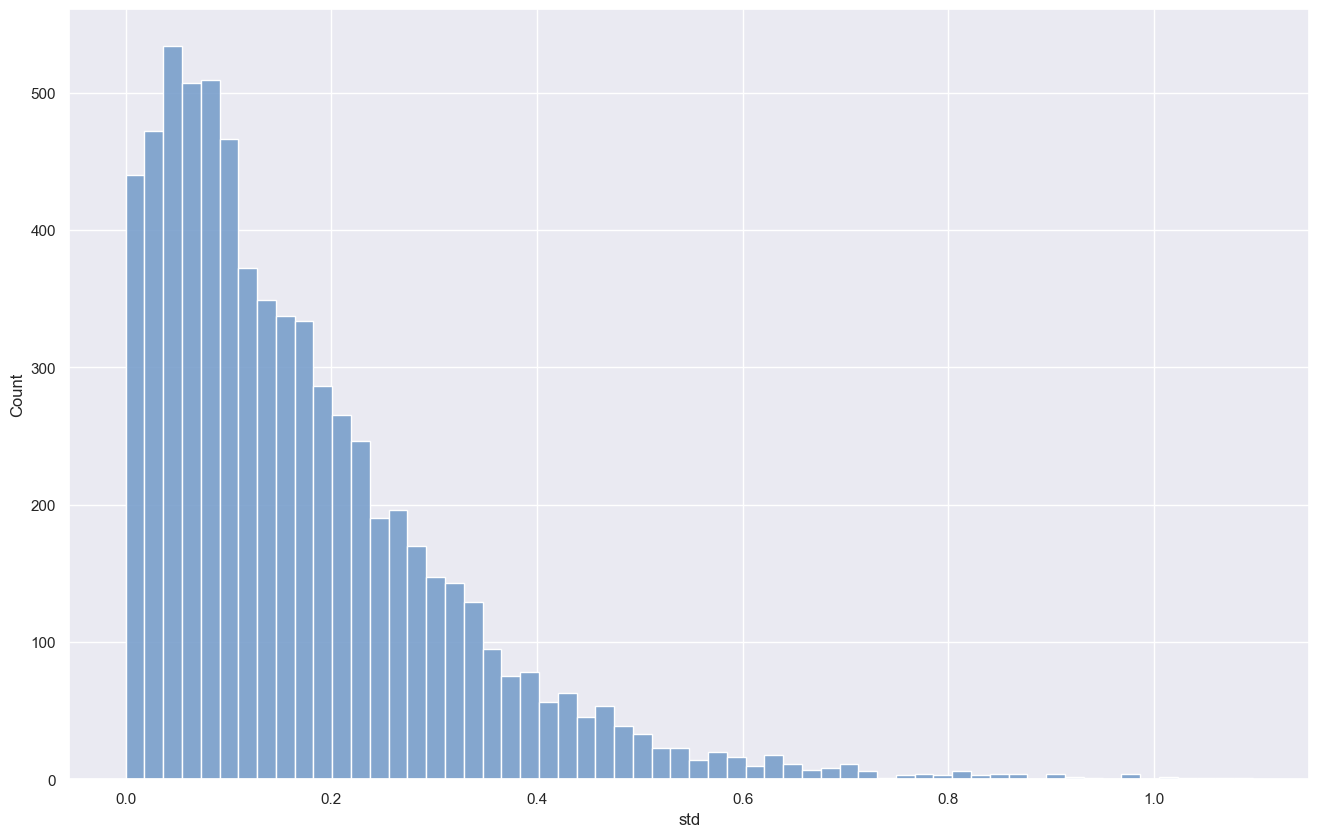

In [37]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'standard',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-standard-drop-' + name)
	)

	matplotlib.pyplot.show()

## 6.2 Transcripts

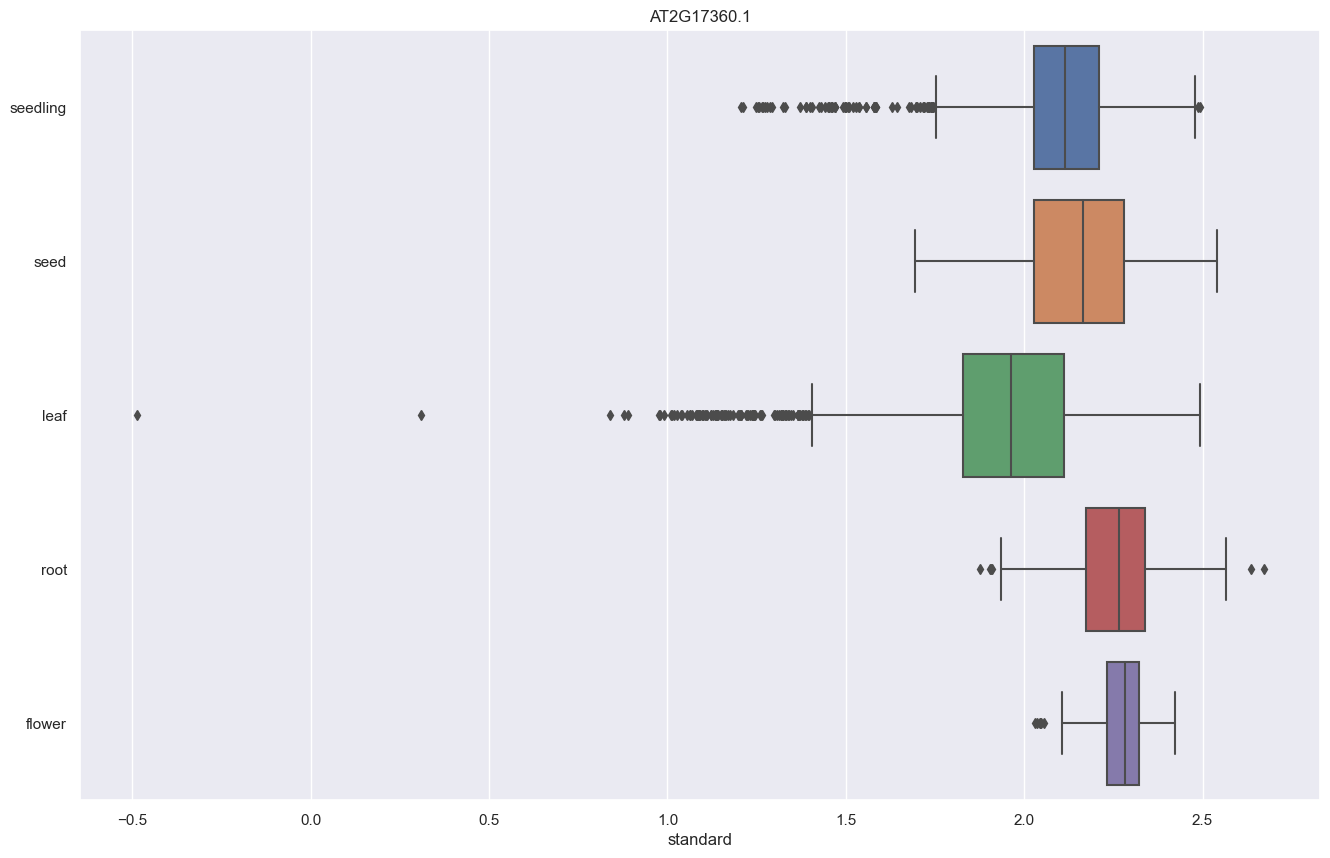

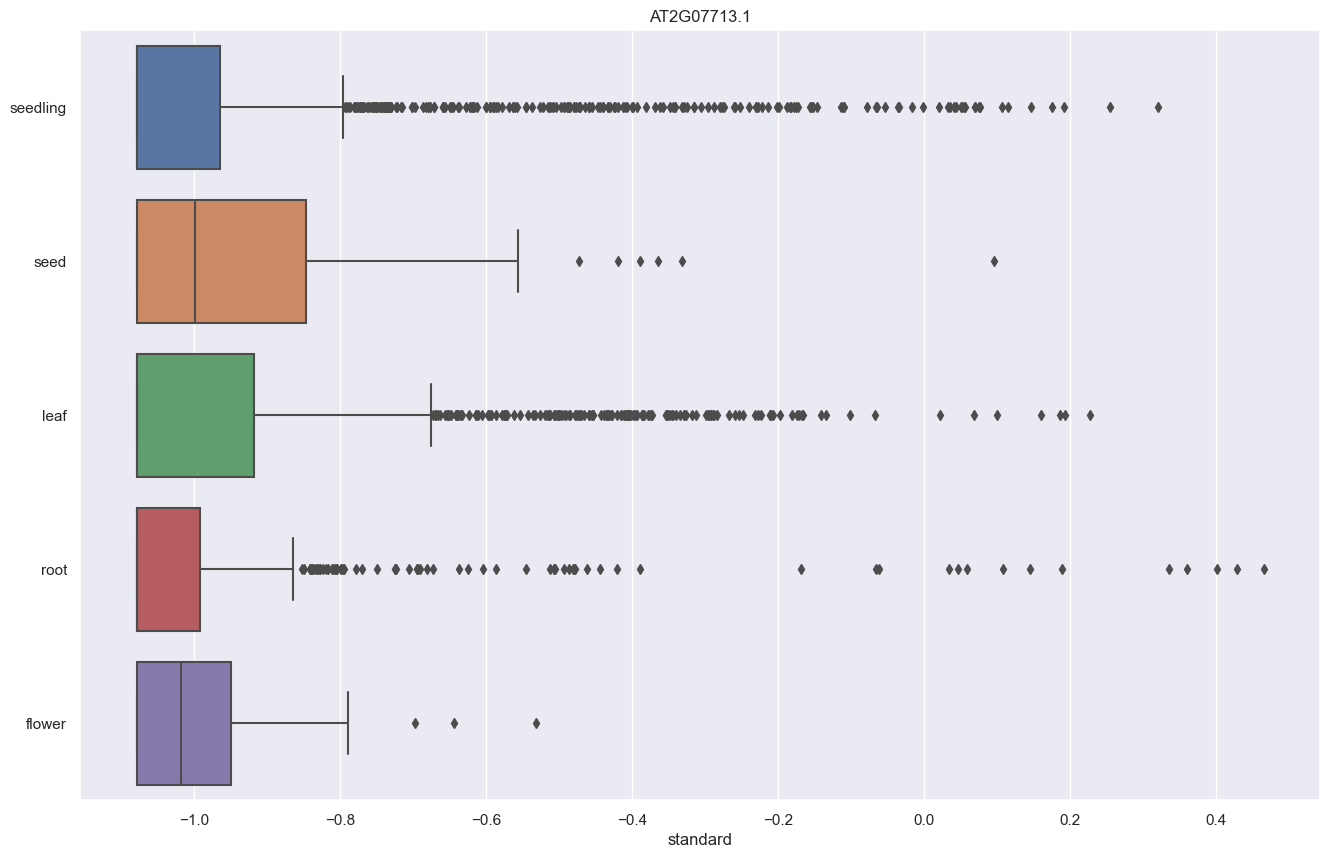

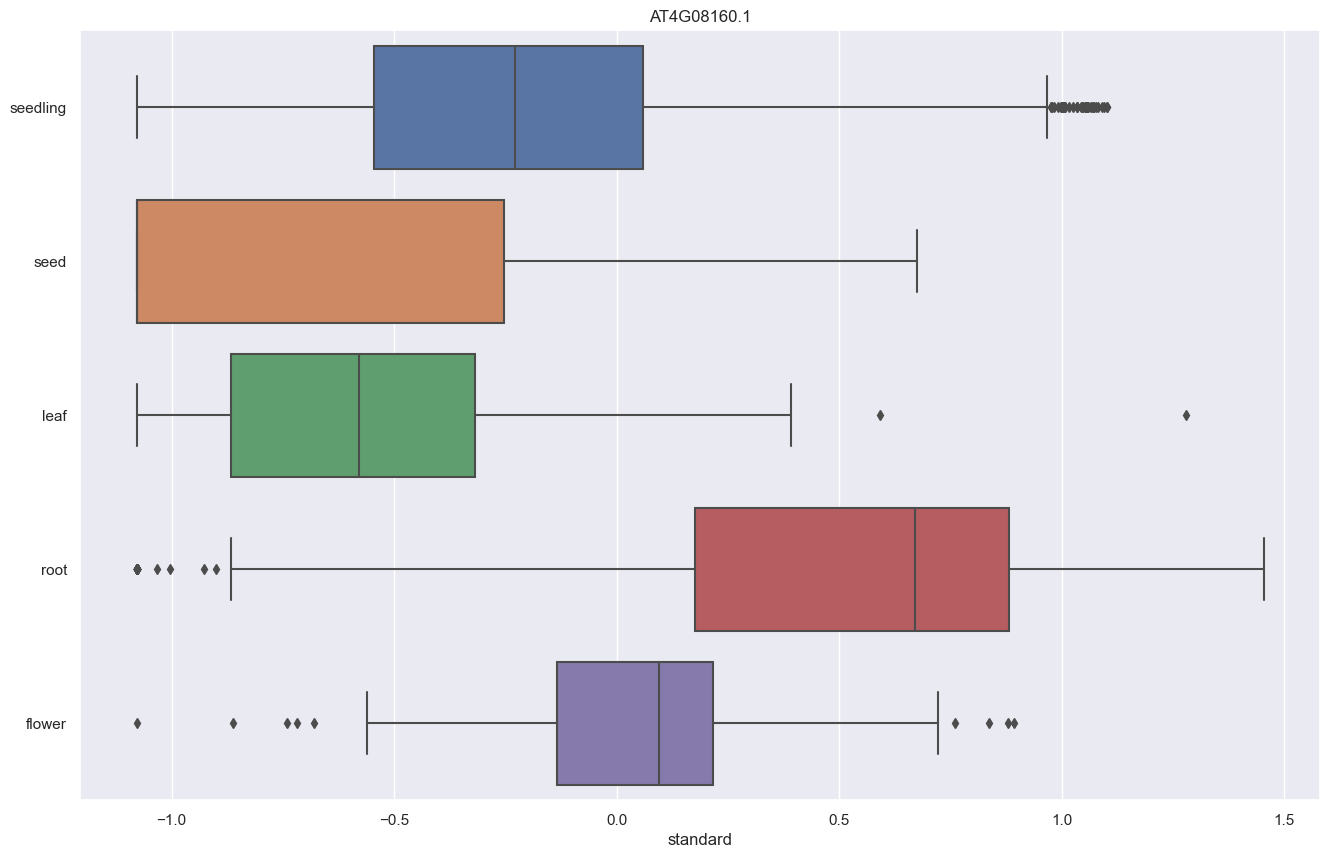

In [38]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'standard',
		filename   = os.path.join(OUT_PLOT, 'tissue-standard-' + transcript)
	)

	matplotlib.pyplot.show()

# 7. Save

In [39]:
# Save the annotated data with multiple layers

writer.write_h5ad(
	data     = anndata,
	filename = os.path.join(OUT_DATA, 'arabidopsis-r36.h5ad')
)

In [40]:
# Save processing info

writer.write_json(
	data     = mapping,
	filename = os.path.join(OUT_DATA, 'layer-mapping.json')
)

writer.write_json(
	data     = boxcox_factors,
	filename = os.path.join(OUT_DATA, 'factors-boxcox.json')
)

writer.write_json(
	data     = normal_factors,
	filename = os.path.join(OUT_DATA, 'factors-normal.json')
)

writer.write_json(
	data     = standard_factors,
	filename = os.path.join(OUT_DATA, 'factors-standard.json')
)

writer.write_csv(
	data        = statistic_log1p_basic,
	filename    = os.path.join(OUT_DATA, 'statistics-log1p-basic.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_log1p_advance,
	filename    = os.path.join(OUT_DATA, 'statistics-log1p-advance.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_log1p_normality,
	filename    = os.path.join(OUT_DATA, 'statistics-log1p-normality.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_boxcox1p_basic,
	filename    = os.path.join(OUT_DATA, 'statistics-boxcox1p-basic.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_boxcox1p_advance,
	filename    = os.path.join(OUT_DATA, 'statistics-boxcox1p-advance.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_boxcox1p_normality,
	filename    = os.path.join(OUT_DATA, 'statistics-boxcox1p-normality.csv'),
	write_index = True
)

# 8. Distributions

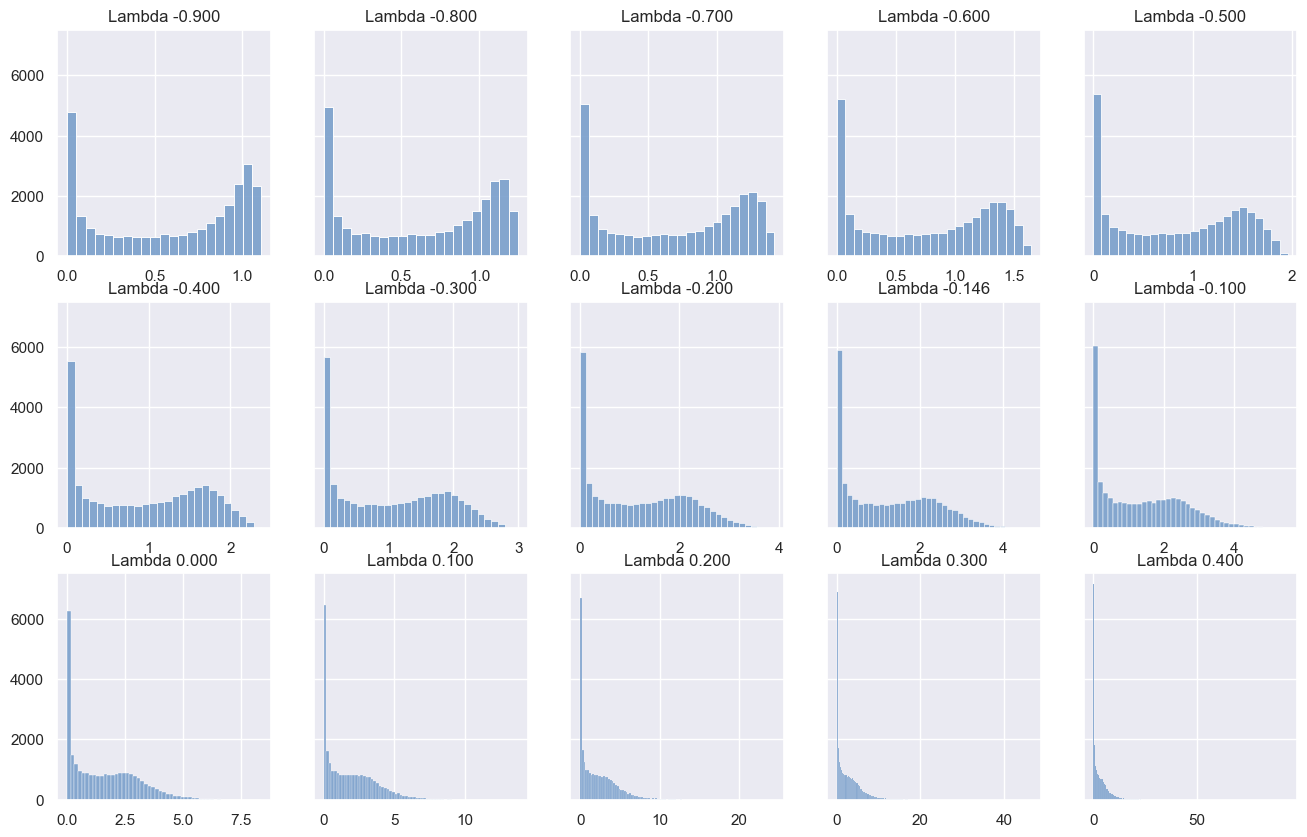

In [41]:
# Plot multiple lambda distributions to compare

LMBDA = boxcox_factors['lambda']
EPS   = boxcox_factors['eps']

lambdas = sorted([
	-0.9, -0.8, -0.7, -0.6, -0.5,
	-0.4, -0.3, -0.2, -0.1,  0.0,
	 0.1,  0.2,  0.3,  0.4, LMBDA
])

fig, ax = matplotlib.pyplot.subplots(
	nrows   = 3,
	ncols   = 5,
	figsize = (16, 10),
	sharex  = False,
	sharey  = True
)

for index, lmbda in enumerate(lambdas) :
	if lmbda is None :
		matrix = anndata.X
		title  = 'Original'
	else :
		layer = 'boxcox1p-{}'.format(index)

		anndata, _ = feature_anndata.compute_boxcox1p(
			data       = anndata,
			store_into = layer,
			layer      = None,
			eps        = EPS,
			lmbda      = lmbda
		)

		matrix = anndata.layers[layer]
		title  = 'Lambda {:.3f}'.format(lmbda)

	irow = index // 5
	icol = index  % 5

	data = pandas.DataFrame.from_dict({
		'Values' : numpy.mean(matrix, axis = 0)
	})

	seaborn.histplot(
		data  = data,
		x     = 'Values',
		alpha = 0.9,
		color = '#799FCB',
		ax    = ax[irow, icol],
		kde   = False
	)

	ax[irow, icol].set_title(title, loc = 'center')
	ax[irow, icol].set_ylabel(None)
	ax[irow, icol].set_xlabel(None)

matplotlib.pyplot.savefig(
	os.path.join(OUT_PLOT, 'distribution-lambda.png'),
	dpi    = 120,
	format = 'png'
)